In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import random
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import models
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: viinod9 (viinod9-iitm). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# CNN

In [3]:
# Defining a custom Convolutional Neural Network (CNN) class
class CNN_Custom(nn.Module):
    def __init__(
        self,
        input_channels=3,  # Number of input channels, e.g., 3 for RGB images
        conv_filters=[32, 64, 128, 256, 512],  # Number of filters for each conv layer
        kernel_sizes=[3, 3, 3, 3, 3],  # Kernel size for each conv layer
        activation_fn=F.relu,  # Activation function to be used after conv layers
        dense_neurons=256,  # Number of neurons in the fully connected hidden layer
        dense_activation_fn=F.relu,  # Activation function after dense layer
        dropout=0.0,  # Dropout rate (0 means no dropout)
        batch_norm=False,  # Whether to apply batch normalization after conv layers
        num_classes=10  # Number of output classes (for classification)
    ):
        # Initializing the parent nn.Module class
        super(CNN_Custom, self).__init__()

        # Saving configuration values
        self.activation_fn = activation_fn
        self.dense_activation_fn = dense_activation_fn
        self.dropout = dropout
        self.batch_norm = batch_norm

        # Initializing a list to hold all convolutional blocks
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels  # Start with input channels (e.g., 3 for RGB)

        # Creating convolutional layers one by one
        for out_channels, kernel_size in zip(conv_filters, kernel_sizes):
            layers = []

            # Add convolutional layer with given kernel size and padding
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))

            # Optionally add batch normalization
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))

            # Add max pooling layer to reduce spatial dimensions
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            # Group the layers into a sequential block and add to the list
            self.conv_layers.append(nn.Sequential(*layers))

            # Update input channel count for the next conv layer
            in_channels = out_channels

        # Creating a dummy input tensor to compute the size after flattening
        self._dummy_input = torch.zeros(1, input_channels, 224, 224)

        # Compute the flattened size of the feature map after all conv layers
        self.flattened_size = self._get_flattened_size()

        # Defining the first fully connected (dense) layer
        fc1_layers = []

        # Optionally add dropout before dense layer to reduce overfitting
        if dropout > 0:
            fc1_layers.append(nn.Dropout(dropout))

        # Add a linear layer from flattened input to dense_neurons
        fc1_layers.append(nn.Linear(self.flattened_size, dense_neurons))
        self.fc1 = nn.Sequential(*fc1_layers)

        # Final output layer from dense_neurons to number of classes
        self.fc2 = nn.Linear(dense_neurons, num_classes)

    # Helper function to calculate the flattened size after conv layers
    def _get_flattened_size(self):
        x = self._dummy_input

        # Pass the dummy input through all conv blocks
        for block in self.conv_layers:
            for layer in block:
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
                    x = layer(x)
                elif isinstance(layer, nn.MaxPool2d):
                    x = layer(x)

        # Flatten the output and return the number of features
        return x.view(1, -1).size(1)

    # Forward pass of the network
    def forward(self, x):
        # Pass the input through each conv block
        for block in self.conv_layers:
            for layer in block:
                if isinstance(layer, nn.Conv2d):
                    # Apply convolution and then activation
                    x = layer(x)
                    x = self.activation_fn(x)
                else:
                    # Apply either batch norm or max pooling
                    x = layer(x)

        # Flatten the output before feeding into dense layers
        x = x.view(x.size(0), -1)

        # Pass through first dense layer
        x = self.fc1(x)

        # Apply activation function
        x = self.dense_activation_fn(x)

        # Pass through final output layer
        x = self.fc2(x)

        # Return the final output (logits)
        return x


# Model Checking

In [5]:
# ----------------- Model Instantiation Example -----------------

# I am creating an instance of the CNN_Custom class by specifying
# various hyperparameters like number of input channels, convolution filters,
# kernel sizes, activation functions, dropout rate, and whether to apply batch normalization.

# input_channels=3        → For RGB images (3 channels: Red, Green, Blue)
# conv_filters            → List specifying number of filters in each conv layer
# kernel_sizes            → List specifying the size of the kernel for each conv layer
# activation_fn           → Activation function to apply after each conv layer (here, ReLU)
# dense_neurons=128       → Number of neurons in the hidden dense (fully connected) layer
# dense_activation_fn     → Activation function after the dense layer
# dropout=0.3             → 30% dropout applied before the dense layer (helps prevent overfitting)
# batch_norm=True         → Apply batch normalization after conv layers (stabilizes training)
# num_classes=10          → Final output layer will have 10 units 

model = CNN_Custom(
    input_channels=3,
    conv_filters=[16, 32, 64, 128, 256],
    kernel_sizes=[3, 3, 3, 3, 3],
    activation_fn=F.relu,
    dense_neurons=128,
    dense_activation_fn=F.relu,
    dropout=0.3,
    batch_norm=True,
    num_classes=10
)

# Print the architecture of the model to verify its structure
print(model)

CNN_Custom(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNo

In [4]:
# ------------- Activation map -------------------
# A dictionary mapping string names to PyTorch activation function modules.
# This allows dynamic selection of activation functions using a simple name.
activation_map = {
    "relu": nn.ReLU(),
    "gelu": nn.GELU(),
    "silu": nn.SiLU(),
    "mish": nn.Mish()
}

# Returns the chosen activation function wrapped in a lambda for usage.
def get_activation_fn(name):
    return lambda x: activation_map[name.lower()](x)


# ------------- Dataset Loading and Split -------------------
# Loads image data from a directory and splits it into train/validation sets.
# Applies augmentation if required and returns PyTorch DataLoaders.
def get_dataloaders(data_dir, batch_size, val_split=0.2, augment=False):
    # Define transformation pipeline for training data
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),   # Data augmentation - flips image
        transforms.RandomRotation(10),       # Data augmentation - rotates image
        transforms.ToTensor()
    ]) if augment else transforms.Compose([
        transforms.Resize((224, 224)),       # Only resizing and converting to tensor
        transforms.ToTensor()
    ])

    # Define transformation pipeline for validation data
    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load the full dataset (from 'train' folder) using training transform
    full_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)

    # Group indices of images by their class labels for stratified splitting
    label_to_indices = {}
    for idx, (_, label) in enumerate(full_dataset.samples):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)

    train_idx = []
    val_idx = []

    # Stratified split: maintain class distribution in both train and val sets
    for label in label_to_indices:
        indices = label_to_indices[label]
        random.shuffle(indices)
        split = int(len(indices) * val_split)
        val_idx.extend(indices[:split])
        train_idx.extend(indices[split:])

    # Create Subset objects for training and validation
    train_data = Subset(full_dataset, train_idx)
    val_data = Subset(ImageFolder(os.path.join(data_dir, 'train'), transform=transform_val), val_idx)

    # Wrap the subsets in DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

    # Return loaders and number of classes
    return train_loader, val_loader, len(full_dataset.classes)


# ------------- Training and Evaluation Functions -------------------

# One training pass through the dataset (single epoch)
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()  # Set model to training mode
    running_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()             # Clear gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                   # Backward pass
        optimizer.step()                  # Update model parameters

        running_loss += loss.item()
        _, predicted = outputs.max(1)     # Get class predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()  # Count correct predictions

    # Return average loss and accuracy for the epoch
    return running_loss / len(dataloader), 100. * correct / total


# Evaluation function (no gradient calculation)
def evaluate(model, criterion, dataloader, device):
    model.eval()  # Set model to evaluation mode
    loss, correct, total = 0, 0, 0

    with torch.no_grad():  # No gradient updates during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Return average validation loss and accuracy
    return loss / len(dataloader), 100. * correct / total


# ------------- Train Loop for wandb Sweep -------------------
# Full training loop for use with wandb hyperparameter sweeps
def train(config=None):
    with wandb.init(config=config):  # Start a new wandb run
        config = wandb.config  # Get sweep config

        # 🔽 Generate a unique name for each run based on config
        run_name = (
            f"filt-{config.base_filter}_{config.filter_organization}_"
            f"act-{config.activation_fn}_bn-{config.batch_norm}_"
            f"do-{config.dropout}_dense-{config.dense_neurons}_"
            f"bs-{config.batch_size}_lr-{config.lr}_aug-{config.data_augmentation}"
        )
        wandb.run.name = run_name

        # Set the device to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load data loaders with optional augmentation
        train_loader, val_loader, num_classes = get_dataloaders(
            data_dir='/kaggle/input/inaturalist-dataset/inaturalist_12K',
            batch_size=config.batch_size,
            val_split=0.2,
            augment=config.data_augmentation
        )

        # Select filter sizes based on the selected strategy: same, double, or half
        conv_filters = {
            'same': [config.base_filter]*5,
            'double': [config.base_filter*(2**i) for i in range(5)],
            'half': [config.base_filter//(2**i) for i in range(5)],
        }[config.filter_organization]

        # Instantiate the CNN model with selected hyperparameters
        model = CNN_Custom(
            conv_filters=conv_filters,
            kernel_sizes=[3]*5,
            activation_fn=get_activation_fn(config.activation_fn),
            dense_neurons=config.dense_neurons,
            dense_activation_fn=F.relu,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            num_classes=num_classes
        )

        model.to(device)  # Move model to GPU/CPU

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.lr)

        # Run training for specified number of epochs
        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = evaluate(model, criterion, val_loader, device)

            # Print progress like Keras-style format
            print(f"Epoch : {epoch + 1}/{config.epochs}")
            print(f" -- Train Accuracy: {train_acc:.4f} -- Validation Accuracy: {val_acc:.4f}")

            # Log metrics to wandb for visualization
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })


# Random Search with 10 Runs

In [4]:
# ------------- Sweep Config

sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'base_filter': {'values': [32, 64]},
        'filter_organization': {'values': ['same', 'double', 'half']},
        'activation_fn': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'data_augmentation': {'values': [True, False]},
        'batch_norm': {'values': [True, False]},
        'dropout': {'values': [0.2, 0.3]},
        'dense_neurons': {'values': [128, 256]},
        'batch_size': {'values': [32, 64, 128]},
        'lr': {'values': [1e-3, 1e-4]},
        'epochs': {'values': [5, 7, 10, 15, 17, 20]}
    }
}

sweep_id = wandb.sweep(sweep_config, project='iNaturalist-CNN')
wandb.agent(sweep_id, function=train, count = 10)

Create sweep with ID: rhf91n3b
Sweep URL: https://wandb.ai/viinod9-iitm/iNaturalist-CNN/sweeps/rhf91n3b


wandb: Agent Starting Run: 3rvrrarz with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch 1/20
 - train_acc: 24.5125 - val_acc: 27.2136
Epoch 2/20
 - train_acc: 35.5125 - val_acc: 33.3667
Epoch 3/20
 - train_acc: 39.1875 - val_acc: 35.8679
Epoch 4/20
 - train_acc: 43.9750 - val_acc: 37.0685
Epoch 5/20
 - train_acc: 48.1125 - val_acc: 37.5188
Epoch 6/20
 - train_acc: 52.9750 - val_acc: 39.1696
Epoch 7/20
 - train_acc: 57.6125 - val_acc: 38.1691
Epoch 8/20
 - train_acc: 62.0625 - val_acc: 38.3692
Epoch 9/20
 - train_acc: 66.3875 - val_acc: 37.8689
Epoch 10/20
 - train_acc: 70.2875 - val_acc: 39.0195
Epoch 11/20
 - train_acc: 74.1375 - val_acc: 39.7199
Epoch 12/20
 - train_acc: 77.6250 - val_acc: 39.7199
Epoch 13/20
 - train_acc: 81.1875 - val_acc: 38.1191
Epoch 14/20
 - train_acc: 82.7125 - val_acc: 38.6193
Epoch 15/20
 - train_acc: 85.8500 - val_acc: 37.9690
Epoch 16/20
 - train_acc: 87.7000 - val_acc: 38.1691
Epoch 17/20
 - train_acc: 88.9125 - val_acc: 38.5693
Epoch 18/20
 - train_acc: 90.4750 - val_acc: 38.8194
Epoch 19/20
 - train_acc: 91.5500 - val_acc: 37.4187
Ep

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▃▃▄▄▅▅▆▆▆▇▇▇█████
train_loss,█▇▇▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▇▇█▇▇▇███▇▇▇▇▇▇▇█
val_loss,▅▃▂▂▁▁▁▂▂▂▂▃▄▅▆▆▆▇▇█
epoch,20
train_acc,92.2875
train_loss,0.29609
val_acc,39.21961
val_loss,2.24192


wandb: Agent Starting Run: v29mxmos with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 17
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch 1/17
 - train_acc: 20.6750 - val_acc: 23.4617
Epoch 2/17
 - train_acc: 28.3500 - val_acc: 30.5153
Epoch 3/17
 - train_acc: 31.1875 - val_acc: 32.1661
Epoch 4/17
 - train_acc: 33.7500 - val_acc: 34.1171
Epoch 5/17
 - train_acc: 35.6625 - val_acc: 34.8674
Epoch 6/17
 - train_acc: 36.7625 - val_acc: 34.7674
Epoch 7/17
 - train_acc: 37.6625 - val_acc: 35.4677
Epoch 8/17
 - train_acc: 39.2375 - val_acc: 35.7679
Epoch 9/17
 - train_acc: 39.4625 - val_acc: 36.7684
Epoch 10/17
 - train_acc: 41.3750 - val_acc: 36.4682
Epoch 11/17
 - train_acc: 42.0000 - val_acc: 36.3682
Epoch 12/17
 - train_acc: 43.0500 - val_acc: 38.0190
Epoch 13/17
 - train_acc: 43.3125 - val_acc: 37.6188
Epoch 14/17
 - train_acc: 44.4500 - val_acc: 38.1691
Epoch 15/17
 - train_acc: 45.4375 - val_acc: 36.9685
Epoch 16/17
 - train_acc: 46.1000 - val_acc: 38.9695
Epoch 17/17
 - train_acc: 46.3125 - val_acc: 38.0690


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_acc,▁▃▄▅▅▅▆▆▆▇▇▇▇▇███
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▄▅▆▆▆▆▇▇▇▇█▇█▇██
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,17
train_acc,46.3125
train_loss,1.53621
val_acc,38.06903
val_loss,1.76564


wandb: Agent Starting Run: jhkdq6ks with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch 1/7
 - train_acc: 20.9375 - val_acc: 22.1111
Epoch 2/7
 - train_acc: 28.5625 - val_acc: 27.8139
Epoch 3/7
 - train_acc: 32.0125 - val_acc: 30.7654
Epoch 4/7
 - train_acc: 35.9000 - val_acc: 30.6653
Epoch 5/7
 - train_acc: 38.9000 - val_acc: 31.2656
Epoch 6/7
 - train_acc: 42.0375 - val_acc: 34.7174
Epoch 7/7
 - train_acc: 46.3500 - val_acc: 32.7664


epoch,▁▂▃▅▆▇█
train_acc,▁▃▄▅▆▇█
train_loss,█▄▄▃▂▂▁
val_acc,▁▄▆▆▆█▇
val_loss,█▄▂▃▃▁▄
epoch,7
train_acc,46.35
train_loss,1.5309
val_acc,32.76638
val_loss,2.06289


wandb: Agent Starting Run: 6vdsv8y0 with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch 1/20
 - train_acc: 14.2875 - val_acc: 23.1616
Epoch 2/20
 - train_acc: 23.5875 - val_acc: 26.2631
Epoch 3/20
 - train_acc: 28.0375 - val_acc: 30.7654
Epoch 4/20
 - train_acc: 30.8500 - val_acc: 32.0160
Epoch 5/20
 - train_acc: 32.7500 - val_acc: 32.8164
Epoch 6/20
 - train_acc: 33.9375 - val_acc: 33.8169
Epoch 7/20
 - train_acc: 36.2750 - val_acc: 34.9675
Epoch 8/20
 - train_acc: 38.2875 - val_acc: 34.7674
Epoch 9/20
 - train_acc: 40.1375 - val_acc: 36.0180
Epoch 10/20
 - train_acc: 41.7750 - val_acc: 36.0180
Epoch 11/20
 - train_acc: 44.3875 - val_acc: 38.2691
Epoch 12/20
 - train_acc: 46.0375 - val_acc: 35.9180
Epoch 13/20
 - train_acc: 49.6250 - val_acc: 37.9690
Epoch 14/20
 - train_acc: 52.3375 - val_acc: 39.2696
Epoch 15/20
 - train_acc: 55.4125 - val_acc: 36.9685
Epoch 16/20
 - train_acc: 58.6875 - val_acc: 37.4687
Epoch 17/20
 - train_acc: 62.7625 - val_acc: 37.7689
Epoch 18/20
 - train_acc: 66.3875 - val_acc: 38.7694
Epoch 19/20
 - train_acc: 70.2000 - val_acc: 38.3692
Ep

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇██
train_loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▂▂▁▁
val_acc,▁▂▄▅▅▆▆▆▇▇█▇▇█▇▇▇███
val_loss,▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▃▄▆▇█
epoch,20
train_acc,72.925
train_loss,0.79685
val_acc,38.91946
val_loss,2.36633


wandb: Agent Starting Run: thtdd7hq with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch 1/15
 - train_acc: 16.4125 - val_acc: 22.9115
Epoch 2/15
 - train_acc: 23.4000 - val_acc: 28.1141
Epoch 3/15
 - train_acc: 29.4125 - val_acc: 28.6143
Epoch 4/15
 - train_acc: 31.5875 - val_acc: 27.9140
Epoch 5/15
 - train_acc: 35.0500 - val_acc: 30.7654
Epoch 6/15
 - train_acc: 37.5375 - val_acc: 29.9150
Epoch 7/15
 - train_acc: 42.5750 - val_acc: 32.8164
Epoch 8/15
 - train_acc: 50.1375 - val_acc: 32.0660
Epoch 9/15
 - train_acc: 61.3125 - val_acc: 33.6668
Epoch 10/15
 - train_acc: 75.8625 - val_acc: 30.9655
Epoch 11/15
 - train_acc: 87.2750 - val_acc: 29.4647
Epoch 12/15
 - train_acc: 93.2625 - val_acc: 31.1656
Epoch 13/15
 - train_acc: 95.0375 - val_acc: 30.6153
Epoch 14/15
 - train_acc: 97.2375 - val_acc: 32.3162
Epoch 15/15
 - train_acc: 97.9875 - val_acc: 30.3152


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▂▂▃▃▃▄▅▆▇████
train_loss,██▇▇▇▇▆▅▄▃▂▁▁▁▁
val_acc,▁▄▅▄▆▆▇▇█▆▅▆▆▇▆
val_loss,▁▁▁▁▁▁▁▁▂▃▅▆▆▇█
epoch,15
train_acc,97.9875
train_loss,0.06509
val_acc,30.31516
val_loss,5.16532


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0eyfdgzj with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch 1/20
 - train_acc: 12.7750 - val_acc: 15.7079
Epoch 2/20
 - train_acc: 20.1375 - val_acc: 22.1111
Epoch 3/20
 - train_acc: 23.0375 - val_acc: 25.0125
Epoch 4/20
 - train_acc: 25.6750 - val_acc: 26.5633
Epoch 5/20
 - train_acc: 28.5375 - val_acc: 28.3642
Epoch 6/20
 - train_acc: 30.6750 - val_acc: 30.9155
Epoch 7/20
 - train_acc: 33.5750 - val_acc: 32.8664
Epoch 8/20
 - train_acc: 35.0625 - val_acc: 33.9670
Epoch 9/20
 - train_acc: 36.2250 - val_acc: 34.5673
Epoch 10/20
 - train_acc: 38.3875 - val_acc: 34.7174
Epoch 11/20
 - train_acc: 38.6375 - val_acc: 37.1686
Epoch 12/20
 - train_acc: 40.3625 - val_acc: 35.3677
Epoch 13/20
 - train_acc: 42.2000 - val_acc: 38.9695
Epoch 14/20
 - train_acc: 43.6375 - val_acc: 39.3697
Epoch 15/20
 - train_acc: 44.9625 - val_acc: 40.1201
Epoch 16/20
 - train_acc: 44.6875 - val_acc: 38.5693
Epoch 17/20
 - train_acc: 46.6500 - val_acc: 39.4697
Epoch 18/20
 - train_acc: 48.4250 - val_acc: 40.4702
Epoch 19/20
 - train_acc: 49.7625 - val_acc: 39.4197
Ep

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
train_loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▃▄▄▅▅▆▆▆▆▇▇███▇████
val_loss,█▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▂▂
epoch,20
train_acc,51.7375
train_loss,1.38903
val_acc,38.76938
val_loss,1.80903


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: loygrwzb with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch 1/20
 - train_acc: 13.4875 - val_acc: 16.7584
Epoch 2/20
 - train_acc: 20.3625 - val_acc: 23.9120
Epoch 3/20
 - train_acc: 24.1500 - val_acc: 25.8129
Epoch 4/20
 - train_acc: 25.2625 - val_acc: 27.2636
Epoch 5/20
 - train_acc: 27.4000 - val_acc: 29.3647
Epoch 6/20
 - train_acc: 27.8875 - val_acc: 29.8149
Epoch 7/20
 - train_acc: 29.0750 - val_acc: 30.5153
Epoch 8/20
 - train_acc: 31.2625 - val_acc: 31.3157
Epoch 9/20
 - train_acc: 31.5625 - val_acc: 31.1656
Epoch 10/20
 - train_acc: 32.1875 - val_acc: 31.6658
Epoch 11/20
 - train_acc: 32.7000 - val_acc: 31.7659
Epoch 12/20
 - train_acc: 33.3875 - val_acc: 32.8664
Epoch 13/20
 - train_acc: 34.5500 - val_acc: 33.3667
Epoch 14/20
 - train_acc: 34.3875 - val_acc: 32.5663
Epoch 15/20
 - train_acc: 35.5750 - val_acc: 33.1666
Epoch 16/20
 - train_acc: 35.2125 - val_acc: 34.9175
Epoch 17/20
 - train_acc: 36.2125 - val_acc: 32.2161
Epoch 18/20
 - train_acc: 37.0125 - val_acc: 33.9170
Epoch 19/20
 - train_acc: 37.6875 - val_acc: 34.6173
Ep

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_acc,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇█▇███
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_acc,38.0125
train_loss,1.76952
val_acc,34.46723
val_loss,1.87033


wandb: Agent Starting Run: qud7o5yt with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch 1/15
 - train_acc: 13.5750 - val_acc: 18.2091
Epoch 2/15
 - train_acc: 19.9375 - val_acc: 21.1606
Epoch 3/15
 - train_acc: 22.7000 - val_acc: 22.1111
Epoch 4/15
 - train_acc: 25.3125 - val_acc: 22.8614
Epoch 5/15
 - train_acc: 25.6750 - val_acc: 24.3122
Epoch 6/15
 - train_acc: 27.6125 - val_acc: 24.9625
Epoch 7/15
 - train_acc: 27.7875 - val_acc: 25.1626
Epoch 8/15
 - train_acc: 28.3125 - val_acc: 25.9630
Epoch 9/15
 - train_acc: 28.8750 - val_acc: 27.1136
Epoch 10/15
 - train_acc: 29.9125 - val_acc: 27.3637
Epoch 11/15
 - train_acc: 29.5000 - val_acc: 27.6638
Epoch 12/15
 - train_acc: 30.6000 - val_acc: 28.8144
Epoch 13/15
 - train_acc: 30.8500 - val_acc: 29.7649
Epoch 14/15
 - train_acc: 31.0625 - val_acc: 28.7644
Epoch 15/15
 - train_acc: 32.0000 - val_acc: 29.1646


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▅▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▃▃▄▅▅▅▆▆▇▇▇█▇█
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁
epoch,15
train_acc,32
train_loss,1.93201
val_acc,29.16458
val_loss,2.02178


wandb: Agent Starting Run: t8rojjoe with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch 1/5
 - train_acc: 26.6375 - val_acc: 28.3142
Epoch 2/5
 - train_acc: 36.3125 - val_acc: 32.8164
Epoch 3/5
 - train_acc: 40.9875 - val_acc: 34.9175
Epoch 4/5
 - train_acc: 45.3000 - val_acc: 35.9180
Epoch 5/5
 - train_acc: 49.4500 - val_acc: 36.7184


epoch,▁▃▅▆█
train_acc,▁▄▅▇█
train_loss,█▅▄▂▁
val_acc,▁▅▆▇█
val_loss,█▃▂▁▁
epoch,5
train_acc,49.45
train_loss,1.49929
val_acc,36.71836
val_loss,1.8236


wandb: Agent Starting Run: g0p4uj7t with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch 1/15
 - train_acc: 11.6875 - val_acc: 12.8564
Epoch 2/15
 - train_acc: 12.7375 - val_acc: 10.8554
Epoch 3/15
 - train_acc: 13.2750 - val_acc: 15.4077
Epoch 4/15
 - train_acc: 13.6250 - val_acc: 14.7574
Epoch 5/15
 - train_acc: 14.2625 - val_acc: 13.9070
Epoch 6/15
 - train_acc: 15.2375 - val_acc: 14.6573
Epoch 7/15
 - train_acc: 15.5375 - val_acc: 15.0575
Epoch 8/15
 - train_acc: 15.3125 - val_acc: 15.7579
Epoch 9/15
 - train_acc: 15.7875 - val_acc: 15.3077
Epoch 10/15
 - train_acc: 15.7500 - val_acc: 16.3082
Epoch 11/15
 - train_acc: 16.3625 - val_acc: 15.1576
Epoch 12/15
 - train_acc: 16.7875 - val_acc: 15.1076
Epoch 13/15
 - train_acc: 16.8250 - val_acc: 15.9080
Epoch 14/15
 - train_acc: 17.1375 - val_acc: 17.8589
Epoch 15/15
 - train_acc: 17.2625 - val_acc: 16.2081


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▃▃▄▅▆▆▆▆▇▇▇██
train_loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▃▁▆▅▄▅▅▆▅▆▅▅▆█▆
val_loss,▃█▂▂▃▂▂▃▂▁▂▂▁▁▁
epoch,15
train_acc,17.2625
train_loss,2.17865
val_acc,16.2081
val_loss,2.1991


# Random Search with 50 Runs

In [5]:
# ------------- Sweep Config

sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'base_filter': {'values': [32, 64]},
        'filter_organization': {'values': ['same', 'double', 'half']},
        'activation_fn': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'data_augmentation': {'values': [True, False]},
        'batch_norm': {'values': [True, False]},
        'dropout': {'values': [0.2, 0.3]},
        'dense_neurons': {'values': [128, 256]},
        'batch_size': {'values': [32, 64, 128]},
        'lr': {'values': [1e-3, 1e-4]},
        'epochs': {'values': [5, 10, 15, 20]}
    }
}

sweep_id = wandb.sweep(sweep_config, project='iNaturalist-CNN-PartA-RandomSearch')
wandb.agent(sweep_id, function=train, count = 50)


Create sweep with ID: jcmht9u1
Sweep URL: https://wandb.ai/viinod9-iitm/iNaturalist-CNN-PartA-RandomSearch/sweeps/jcmht9u1


wandb: Agent Starting Run: hjg7sov0 with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/5
 -- Train Accuracy: 9.3750 -- Validation Accuracy: 10.0050
Epoch : 2/5
 -- Train Accuracy: 9.2750 -- Validation Accuracy: 10.0050
Epoch : 3/5
 -- Train Accuracy: 9.2375 -- Validation Accuracy: 10.0050
Epoch : 4/5
 -- Train Accuracy: 9.6375 -- Validation Accuracy: 10.0050
Epoch : 5/5
 -- Train Accuracy: 9.4375 -- Validation Accuracy: 10.0050


epoch,▁▃▅▆█
train_acc,▃▂▁█▅
train_loss,█▂▁▁▂
val_acc,▁▁▁▁▁
val_loss,▁▃▆█▇
epoch,5
train_acc,9.4375
train_loss,2.30308
val_acc,10.005
val_loss,2.3026


wandb: Agent Starting Run: ydegaatt with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 14.3625 -- Validation Accuracy: 15.6078
Epoch : 2/15
 -- Train Accuracy: 15.6625 -- Validation Accuracy: 17.5588
Epoch : 3/15
 -- Train Accuracy: 17.6750 -- Validation Accuracy: 20.1601
Epoch : 4/15
 -- Train Accuracy: 20.3250 -- Validation Accuracy: 21.9110
Epoch : 5/15
 -- Train Accuracy: 22.2625 -- Validation Accuracy: 21.3107
Epoch : 6/15
 -- Train Accuracy: 22.3125 -- Validation Accuracy: 21.3107
Epoch : 7/15
 -- Train Accuracy: 23.7500 -- Validation Accuracy: 22.8614
Epoch : 8/15
 -- Train Accuracy: 25.5125 -- Validation Accuracy: 24.6123
Epoch : 9/15
 -- Train Accuracy: 26.5125 -- Validation Accuracy: 26.2631
Epoch : 10/15
 -- Train Accuracy: 27.7125 -- Validation Accuracy: 23.2116
Epoch : 11/15
 -- Train Accuracy: 28.3125 -- Validation Accuracy: 25.3127
Epoch : 12/15
 -- Train Accuracy: 30.1500 -- Validation Accuracy: 27.4137
Epoch : 13/15
 -- Train Accuracy: 30.6500 -- Validation Accuracy: 27.7639
Epoch : 14/15
 -- Train Accuracy: 32.2625 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▂▃▄▄▅▅▆▆▆▇▇██
train_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▂▃▄▄▄▄▅▆▄▅▆▇█▇
val_loss,█▇▇▅▅▅▆▃▃▅▃▃▂▁▂
epoch,15
train_acc,33.0625
train_loss,1.83797
val_acc,28.86443
val_loss,1.99238


wandb: Agent Starting Run: 92a9dipb with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/20
 -- Train Accuracy: 9.9125 -- Validation Accuracy: 10.0050
Epoch : 2/20
 -- Train Accuracy: 10.2250 -- Validation Accuracy: 10.0050
Epoch : 3/20
 -- Train Accuracy: 9.4125 -- Validation Accuracy: 10.2051
Epoch : 4/20
 -- Train Accuracy: 9.9875 -- Validation Accuracy: 11.0555
Epoch : 5/20
 -- Train Accuracy: 10.8625 -- Validation Accuracy: 11.0055
Epoch : 6/20
 -- Train Accuracy: 12.5125 -- Validation Accuracy: 13.2066
Epoch : 7/20
 -- Train Accuracy: 13.1250 -- Validation Accuracy: 14.4072
Epoch : 8/20
 -- Train Accuracy: 14.5375 -- Validation Accuracy: 15.5078
Epoch : 9/20
 -- Train Accuracy: 14.9625 -- Validation Accuracy: 16.1581
Epoch : 10/20
 -- Train Accuracy: 15.6500 -- Validation Accuracy: 17.1586
Epoch : 11/20
 -- Train Accuracy: 15.6625 -- Validation Accuracy: 16.7084
Epoch : 12/20
 -- Train Accuracy: 16.2000 -- Validation Accuracy: 18.0090
Epoch : 13/20
 -- Train Accuracy: 16.1750 -- Validation Accuracy: 17.8589
Epoch : 14/20
 -- Train Accuracy: 17.4625 -- Valid

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▁▁▂▃▄▅▅▅▅▆▆▇▇▇▇▇▇█
train_loss,█████▇▆▆▅▅▄▄▄▄▃▂▂▂▂▁
val_acc,▁▁▁▂▂▄▅▅▆▇▆▇▇▇▇█▇███
val_loss,████▇▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
epoch,20
train_acc,19.1375
train_loss,2.20917
val_acc,18.70935
val_loss,2.21745


wandb: Agent Starting Run: s2ml82rm with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 26.7000 -- Validation Accuracy: 32.2661
Epoch : 2/10
 -- Train Accuracy: 36.1750 -- Validation Accuracy: 33.8169
Epoch : 3/10
 -- Train Accuracy: 41.0125 -- Validation Accuracy: 35.5678
Epoch : 4/10
 -- Train Accuracy: 46.0625 -- Validation Accuracy: 38.2691
Epoch : 5/10
 -- Train Accuracy: 51.0625 -- Validation Accuracy: 37.6688
Epoch : 6/10
 -- Train Accuracy: 56.0875 -- Validation Accuracy: 37.3187
Epoch : 7/10
 -- Train Accuracy: 62.4375 -- Validation Accuracy: 37.5688
Epoch : 8/10
 -- Train Accuracy: 67.0000 -- Validation Accuracy: 38.4192
Epoch : 9/10
 -- Train Accuracy: 72.5875 -- Validation Accuracy: 37.7689
Epoch : 10/10
 -- Train Accuracy: 76.7125 -- Validation Accuracy: 38.4692


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_acc,▁▃▅█▇▇▇█▇█
val_loss,█▃▂▁▁▁▂▄██
epoch,10
train_acc,76.7125
train_loss,0.76029
val_acc,38.46923
val_loss,1.95403


wandb: Agent Starting Run: 5z36h8ws with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/5
 -- Train Accuracy: 25.9375 -- Validation Accuracy: 31.9160
Epoch : 2/5
 -- Train Accuracy: 33.2500 -- Validation Accuracy: 34.5673
Epoch : 3/5
 -- Train Accuracy: 36.2750 -- Validation Accuracy: 35.4677
Epoch : 4/5
 -- Train Accuracy: 38.7375 -- Validation Accuracy: 37.4187
Epoch : 5/5
 -- Train Accuracy: 41.0375 -- Validation Accuracy: 37.5688


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▄▅██
val_loss,█▅▄▃▁
epoch,5
train_acc,41.0375
train_loss,1.69439
val_acc,37.56878
val_loss,1.77643


wandb: Agent Starting Run: sdllzjvv with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 14.6000 -- Validation Accuracy: 21.5608
Epoch : 2/15
 -- Train Accuracy: 23.3875 -- Validation Accuracy: 23.1116
Epoch : 3/15
 -- Train Accuracy: 28.3000 -- Validation Accuracy: 28.0140
Epoch : 4/15
 -- Train Accuracy: 30.5625 -- Validation Accuracy: 32.1661
Epoch : 5/15
 -- Train Accuracy: 32.7375 -- Validation Accuracy: 31.1156
Epoch : 6/15
 -- Train Accuracy: 34.5500 -- Validation Accuracy: 33.5668
Epoch : 7/15
 -- Train Accuracy: 36.1625 -- Validation Accuracy: 33.3167
Epoch : 8/15
 -- Train Accuracy: 38.3500 -- Validation Accuracy: 35.2176
Epoch : 9/15
 -- Train Accuracy: 40.6125 -- Validation Accuracy: 35.2176
Epoch : 10/15
 -- Train Accuracy: 42.0250 -- Validation Accuracy: 34.0170
Epoch : 11/15
 -- Train Accuracy: 44.2625 -- Validation Accuracy: 35.6178
Epoch : 12/15
 -- Train Accuracy: 46.1000 -- Validation Accuracy: 33.8169
Epoch : 13/15
 -- Train Accuracy: 48.2875 -- Validation Accuracy: 34.2171
Epoch : 14/15
 -- Train Accuracy: 51.3750 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▂▂▁
val_acc,▁▂▄▆▆▇▇██▇█▇▇▇▇
val_loss,█▇▅▃▃▂▂▁▁▁▂▂▃▄▅
epoch,15
train_acc,54.0875
train_loss,1.31842
val_acc,33.76688
val_loss,2.0481


wandb: Agent Starting Run: i7b45yr0 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 21.1500 -- Validation Accuracy: 26.8634
Epoch : 2/10
 -- Train Accuracy: 27.0625 -- Validation Accuracy: 31.0655
Epoch : 3/10
 -- Train Accuracy: 30.1000 -- Validation Accuracy: 32.5163
Epoch : 4/10
 -- Train Accuracy: 30.9500 -- Validation Accuracy: 33.8669
Epoch : 5/10
 -- Train Accuracy: 32.2750 -- Validation Accuracy: 33.1166
Epoch : 6/10
 -- Train Accuracy: 33.2750 -- Validation Accuracy: 32.9165
Epoch : 7/10
 -- Train Accuracy: 33.5375 -- Validation Accuracy: 26.8634
Epoch : 8/10
 -- Train Accuracy: 34.0000 -- Validation Accuracy: 33.4167
Epoch : 9/10
 -- Train Accuracy: 35.1500 -- Validation Accuracy: 33.3667
Epoch : 10/10
 -- Train Accuracy: 36.3875 -- Validation Accuracy: 29.3147


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇▇▇█
train_loss,█▆▄▄▃▃▂▂▂▁
val_acc,▁▅▇█▇▇▁██▃
val_loss,▅▃▂▂▂▁█▁▁▃
epoch,10
train_acc,36.3875
train_loss,1.80845
val_acc,29.31466
val_loss,1.99056


wandb: Agent Starting Run: nxsr4oxp with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 18.4875 -- Validation Accuracy: 22.6113
Epoch : 2/15
 -- Train Accuracy: 25.2250 -- Validation Accuracy: 20.3602
Epoch : 3/15
 -- Train Accuracy: 28.6250 -- Validation Accuracy: 25.3127
Epoch : 4/15
 -- Train Accuracy: 29.9625 -- Validation Accuracy: 24.8124
Epoch : 5/15
 -- Train Accuracy: 30.9750 -- Validation Accuracy: 31.3657
Epoch : 6/15
 -- Train Accuracy: 32.0500 -- Validation Accuracy: 28.4642
Epoch : 7/15
 -- Train Accuracy: 33.2125 -- Validation Accuracy: 32.8664
Epoch : 8/15
 -- Train Accuracy: 33.4750 -- Validation Accuracy: 32.0660
Epoch : 9/15
 -- Train Accuracy: 35.0875 -- Validation Accuracy: 30.7154
Epoch : 10/15
 -- Train Accuracy: 35.1375 -- Validation Accuracy: 34.6173
Epoch : 11/15
 -- Train Accuracy: 36.2625 -- Validation Accuracy: 32.1161
Epoch : 12/15
 -- Train Accuracy: 37.2000 -- Validation Accuracy: 35.6178
Epoch : 13/15
 -- Train Accuracy: 37.0750 -- Validation Accuracy: 36.5183
Epoch : 14/15
 -- Train Accuracy: 37.1000 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▅▅▆▆▆▆▇▇█████
train_loss,█▆▅▄▄▄▃▃▂▂▂▂▂▁▁
val_acc,▂▁▃▃▆▅▆▆▅▇▆██▆█
val_loss,▆█▅▅▃▃▂▂▃▂▃▁▁▃▂
epoch,15
train_acc,37.6125
train_loss,1.74171
val_acc,35.41771
val_loss,1.87828


wandb: Agent Starting Run: vne392vz with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 16.4125 -- Validation Accuracy: 23.0615
Epoch : 2/15
 -- Train Accuracy: 26.9000 -- Validation Accuracy: 31.7659
Epoch : 3/15
 -- Train Accuracy: 30.4000 -- Validation Accuracy: 31.8159
Epoch : 4/15
 -- Train Accuracy: 32.7500 -- Validation Accuracy: 32.9665
Epoch : 5/15
 -- Train Accuracy: 34.5625 -- Validation Accuracy: 33.7169
Epoch : 6/15
 -- Train Accuracy: 35.5125 -- Validation Accuracy: 38.0190
Epoch : 7/15
 -- Train Accuracy: 37.6500 -- Validation Accuracy: 35.9680
Epoch : 8/15
 -- Train Accuracy: 40.0125 -- Validation Accuracy: 37.4187
Epoch : 9/15
 -- Train Accuracy: 41.9000 -- Validation Accuracy: 39.5698
Epoch : 10/15
 -- Train Accuracy: 44.2000 -- Validation Accuracy: 39.2696
Epoch : 11/15
 -- Train Accuracy: 47.1000 -- Validation Accuracy: 37.7189
Epoch : 12/15
 -- Train Accuracy: 49.1250 -- Validation Accuracy: 37.3187
Epoch : 13/15
 -- Train Accuracy: 51.6000 -- Validation Accuracy: 38.7194
Epoch : 14/15
 -- Train Accuracy: 54.9250 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▃▄▄▄▅▅▅▆▆▆▇▇█
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▂▂▁
val_acc,▁▅▅▅▆▇▆▇██▇▇███
val_loss,█▅▄▄▃▂▂▂▁▁▂▃▃▃▄
epoch,15
train_acc,58.0625
train_loss,1.21447
val_acc,39.11956
val_loss,1.93357


wandb: Agent Starting Run: ixpknrne with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 10.1500 -- Validation Accuracy: 12.0060
Epoch : 2/20
 -- Train Accuracy: 12.8875 -- Validation Accuracy: 16.1081
Epoch : 3/20
 -- Train Accuracy: 17.4000 -- Validation Accuracy: 18.5093
Epoch : 4/20
 -- Train Accuracy: 19.1250 -- Validation Accuracy: 20.7604
Epoch : 5/20
 -- Train Accuracy: 22.3375 -- Validation Accuracy: 24.8124
Epoch : 6/20
 -- Train Accuracy: 25.7375 -- Validation Accuracy: 23.7119
Epoch : 7/20
 -- Train Accuracy: 27.2750 -- Validation Accuracy: 27.4637
Epoch : 8/20
 -- Train Accuracy: 29.7125 -- Validation Accuracy: 28.2641
Epoch : 9/20
 -- Train Accuracy: 30.7375 -- Validation Accuracy: 30.5653
Epoch : 10/20
 -- Train Accuracy: 32.6000 -- Validation Accuracy: 32.1661
Epoch : 11/20
 -- Train Accuracy: 33.7625 -- Validation Accuracy: 30.7654
Epoch : 12/20
 -- Train Accuracy: 34.7500 -- Validation Accuracy: 31.6658
Epoch : 13/20
 -- Train Accuracy: 35.8250 -- Validation Accuracy: 34.9675
Epoch : 14/20
 -- Train Accuracy: 37.2625 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
train_loss,██▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
val_acc,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇█▇▇██
val_loss,██▆▆▅▅▄▄▃▃▃▃▂▂▁▁▂▂▁▁
epoch,20
train_acc,43.5
train_loss,1.60793
val_acc,39.11956
val_loss,1.7894


wandb: Agent Starting Run: zlqzi5f9 with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 13.7625 -- Validation Accuracy: 13.9070
Epoch : 2/20
 -- Train Accuracy: 15.7875 -- Validation Accuracy: 15.9580
Epoch : 3/20
 -- Train Accuracy: 18.3625 -- Validation Accuracy: 18.8594
Epoch : 4/20
 -- Train Accuracy: 20.0750 -- Validation Accuracy: 19.2596
Epoch : 5/20
 -- Train Accuracy: 21.8375 -- Validation Accuracy: 20.6603
Epoch : 6/20
 -- Train Accuracy: 24.3250 -- Validation Accuracy: 23.3117
Epoch : 7/20
 -- Train Accuracy: 25.4500 -- Validation Accuracy: 24.8124
Epoch : 8/20
 -- Train Accuracy: 28.0750 -- Validation Accuracy: 22.1611
Epoch : 9/20
 -- Train Accuracy: 29.1250 -- Validation Accuracy: 25.7629
Epoch : 10/20
 -- Train Accuracy: 30.5500 -- Validation Accuracy: 25.2126
Epoch : 11/20
 -- Train Accuracy: 30.1625 -- Validation Accuracy: 23.9120
Epoch : 12/20
 -- Train Accuracy: 32.4125 -- Validation Accuracy: 27.4637
Epoch : 13/20
 -- Train Accuracy: 33.0125 -- Validation Accuracy: 27.5638
Epoch : 14/20
 -- Train Accuracy: 34.4625 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇██
train_loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▃▃▃▄▅▄▅▅▅▆▆▆▇▅▆█▇█
val_loss,▇▆▆▅▅▄▄█▃▅▃▃▄▃▂▅▃▂▂▁
epoch,20
train_acc,41.0625
train_loss,1.63906
val_acc,33.81691
val_loss,1.9022


wandb: Agent Starting Run: 5ql0du60 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 13.3875 -- Validation Accuracy: 17.4087
Epoch : 2/15
 -- Train Accuracy: 19.1250 -- Validation Accuracy: 18.3092
Epoch : 3/15
 -- Train Accuracy: 21.2375 -- Validation Accuracy: 22.5113
Epoch : 4/15
 -- Train Accuracy: 23.8875 -- Validation Accuracy: 23.6618
Epoch : 5/15
 -- Train Accuracy: 25.6125 -- Validation Accuracy: 24.3122
Epoch : 6/15
 -- Train Accuracy: 27.0125 -- Validation Accuracy: 26.3132
Epoch : 7/15
 -- Train Accuracy: 28.0500 -- Validation Accuracy: 27.1636
Epoch : 8/15
 -- Train Accuracy: 29.7625 -- Validation Accuracy: 28.4142
Epoch : 9/15
 -- Train Accuracy: 31.3875 -- Validation Accuracy: 28.2641
Epoch : 10/15
 -- Train Accuracy: 32.4875 -- Validation Accuracy: 29.4147
Epoch : 11/15
 -- Train Accuracy: 33.8750 -- Validation Accuracy: 29.4147
Epoch : 12/15
 -- Train Accuracy: 33.1250 -- Validation Accuracy: 29.2646
Epoch : 13/15
 -- Train Accuracy: 33.8000 -- Validation Accuracy: 31.0655
Epoch : 14/15
 -- Train Accuracy: 34.0375 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▃▄▅▅▆▆▇▇█▇▇██
train_loss,█▇▆▅▅▄▃▃▂▂▂▂▁▁▁
val_acc,▁▁▃▄▄▅▅▆▆▆▆▆▇▇█
val_loss,██▆▅▅▄▃▂▃▂▂▃▂▂▁
epoch,15
train_acc,35.3875
train_loss,1.83444
val_acc,33.16658
val_loss,1.92604


wandb: Agent Starting Run: xiqhkmwe with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 26.9625 -- Validation Accuracy: 27.9140
Epoch : 2/15
 -- Train Accuracy: 33.5000 -- Validation Accuracy: 32.4662
Epoch : 3/15
 -- Train Accuracy: 36.5375 -- Validation Accuracy: 32.7164
Epoch : 4/15
 -- Train Accuracy: 38.5500 -- Validation Accuracy: 32.8664
Epoch : 5/15
 -- Train Accuracy: 41.4750 -- Validation Accuracy: 33.7169
Epoch : 6/15
 -- Train Accuracy: 43.7125 -- Validation Accuracy: 35.7179
Epoch : 7/15
 -- Train Accuracy: 46.5000 -- Validation Accuracy: 32.4662
Epoch : 8/15
 -- Train Accuracy: 49.0375 -- Validation Accuracy: 37.7189
Epoch : 9/15
 -- Train Accuracy: 50.9250 -- Validation Accuracy: 37.0685
Epoch : 10/15
 -- Train Accuracy: 52.9250 -- Validation Accuracy: 37.3687
Epoch : 11/15
 -- Train Accuracy: 55.4125 -- Validation Accuracy: 39.3697
Epoch : 12/15
 -- Train Accuracy: 57.1125 -- Validation Accuracy: 36.4182
Epoch : 13/15
 -- Train Accuracy: 60.0000 -- Validation Accuracy: 37.9190
Epoch : 14/15
 -- Train Accuracy: 63.4750 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▇▆▆▅▅▅▄▄▃▃▂▂▁▁
val_acc,▁▄▄▄▅▆▄▇▇▇█▆▇█▇
val_loss,█▄▄▃▅▃▅▂▂▂▁▄▃▅▇
epoch,15
train_acc,65.1125
train_loss,1.00235
val_acc,36.96848
val_loss,2.01386


wandb: Agent Starting Run: b1qf48mo with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 21.3750 -- Validation Accuracy: 25.3127
Epoch : 2/10
 -- Train Accuracy: 27.3125 -- Validation Accuracy: 30.3652
Epoch : 3/10
 -- Train Accuracy: 29.4625 -- Validation Accuracy: 31.6658
Epoch : 4/10
 -- Train Accuracy: 32.0000 -- Validation Accuracy: 31.2656
Epoch : 5/10
 -- Train Accuracy: 33.2000 -- Validation Accuracy: 27.0135
Epoch : 6/10
 -- Train Accuracy: 32.6625 -- Validation Accuracy: 30.2151
Epoch : 7/10
 -- Train Accuracy: 34.1375 -- Validation Accuracy: 28.1141
Epoch : 8/10
 -- Train Accuracy: 35.4875 -- Validation Accuracy: 34.1171
Epoch : 9/10
 -- Train Accuracy: 36.4750 -- Validation Accuracy: 35.7179
Epoch : 10/10
 -- Train Accuracy: 36.6375 -- Validation Accuracy: 33.3167


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_acc,▁▄▅▅▂▄▃▇█▆
val_loss,▇▄▄▄█▅▆▃▁▂
epoch,10
train_acc,36.6375
train_loss,1.79596
val_acc,33.31666
val_loss,1.87552


wandb: Agent Starting Run: jewhejgu with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 18.6125 -- Validation Accuracy: 21.9610
Epoch : 2/10
 -- Train Accuracy: 23.9000 -- Validation Accuracy: 23.7119
Epoch : 3/10
 -- Train Accuracy: 26.2375 -- Validation Accuracy: 26.3632
Epoch : 4/10
 -- Train Accuracy: 26.5750 -- Validation Accuracy: 25.9630
Epoch : 5/10
 -- Train Accuracy: 27.3500 -- Validation Accuracy: 27.8639
Epoch : 6/10
 -- Train Accuracy: 28.1750 -- Validation Accuracy: 29.1146
Epoch : 7/10
 -- Train Accuracy: 29.1500 -- Validation Accuracy: 29.1646
Epoch : 8/10
 -- Train Accuracy: 29.7375 -- Validation Accuracy: 26.2131
Epoch : 9/10
 -- Train Accuracy: 30.2125 -- Validation Accuracy: 30.0150
Epoch : 10/10
 -- Train Accuracy: 30.4625 -- Validation Accuracy: 25.6128


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▆▆▇▇███
train_loss,█▅▄▃▃▃▂▂▁▁
val_acc,▁▃▅▄▆▇▇▅█▄
val_loss,▆▆▄▄▂▂▂▃▁█
epoch,10
train_acc,30.4625
train_loss,1.94324
val_acc,25.61281
val_loss,2.1885


wandb: Agent Starting Run: hfz4n2cj with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 9.9875 -- Validation Accuracy: 10.0050
Epoch : 2/15
 -- Train Accuracy: 9.8250 -- Validation Accuracy: 10.0050
Epoch : 3/15
 -- Train Accuracy: 10.6875 -- Validation Accuracy: 11.2056
Epoch : 4/15
 -- Train Accuracy: 13.9500 -- Validation Accuracy: 13.7569
Epoch : 5/15
 -- Train Accuracy: 15.3125 -- Validation Accuracy: 16.1081
Epoch : 6/15
 -- Train Accuracy: 15.7125 -- Validation Accuracy: 15.1076
Epoch : 7/15
 -- Train Accuracy: 16.9375 -- Validation Accuracy: 16.2081
Epoch : 8/15
 -- Train Accuracy: 17.5875 -- Validation Accuracy: 17.5588
Epoch : 9/15
 -- Train Accuracy: 18.5500 -- Validation Accuracy: 17.7589
Epoch : 10/15
 -- Train Accuracy: 18.8500 -- Validation Accuracy: 18.1591
Epoch : 11/15
 -- Train Accuracy: 19.2250 -- Validation Accuracy: 18.7594
Epoch : 12/15
 -- Train Accuracy: 19.3250 -- Validation Accuracy: 19.8099
Epoch : 13/15
 -- Train Accuracy: 19.9875 -- Validation Accuracy: 20.1601
Epoch : 14/15
 -- Train Accuracy: 20.2875 -- Vali

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▂▄▄▅▆▆▇▇▇▇▇██
train_loss,███▇▅▅▄▄▃▃▃▂▂▁▁
val_acc,▁▁▂▃▅▄▅▆▆▆▆▇▇▇█
val_loss,███▆▅▅▄▄▃▃▃▂▂▁▁
epoch,15
train_acc,20.8625
train_loss,2.1623
val_acc,21.21061
val_loss,2.17275


wandb: Agent Starting Run: fv63vhd1 with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 12.5250 -- Validation Accuracy: 18.1091
Epoch : 2/10
 -- Train Accuracy: 21.6500 -- Validation Accuracy: 23.8619
Epoch : 3/10
 -- Train Accuracy: 25.0875 -- Validation Accuracy: 23.4117
Epoch : 4/10
 -- Train Accuracy: 26.9375 -- Validation Accuracy: 26.7134
Epoch : 5/10
 -- Train Accuracy: 28.9250 -- Validation Accuracy: 26.8634
Epoch : 6/10
 -- Train Accuracy: 30.8250 -- Validation Accuracy: 29.9650
Epoch : 7/10
 -- Train Accuracy: 32.9875 -- Validation Accuracy: 30.3652
Epoch : 8/10
 -- Train Accuracy: 35.4500 -- Validation Accuracy: 33.0165
Epoch : 9/10
 -- Train Accuracy: 36.0750 -- Validation Accuracy: 31.8659
Epoch : 10/10
 -- Train Accuracy: 37.8125 -- Validation Accuracy: 32.9165


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▄▅▆▆▇▇██
train_loss,█▆▅▅▄▃▃▂▁▁
val_acc,▁▄▃▅▅▇▇█▇█
val_loss,█▆▅▄▄▃▂▁▂▁
epoch,10
train_acc,37.8125
train_loss,1.7793
val_acc,32.91646
val_loss,1.90266


wandb: Agent Starting Run: muakkbyz with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 9.7750 -- Validation Accuracy: 10.2551
Epoch : 2/15
 -- Train Accuracy: 10.0375 -- Validation Accuracy: 9.3047
Epoch : 3/15
 -- Train Accuracy: 9.9000 -- Validation Accuracy: 9.9550
Epoch : 4/15
 -- Train Accuracy: 10.3250 -- Validation Accuracy: 9.8549
Epoch : 5/15
 -- Train Accuracy: 10.8000 -- Validation Accuracy: 12.4562
Epoch : 6/15
 -- Train Accuracy: 13.8000 -- Validation Accuracy: 14.9575
Epoch : 7/15
 -- Train Accuracy: 16.6125 -- Validation Accuracy: 18.5593
Epoch : 8/15
 -- Train Accuracy: 18.2375 -- Validation Accuracy: 17.8589
Epoch : 9/15
 -- Train Accuracy: 18.7500 -- Validation Accuracy: 18.1591
Epoch : 10/15
 -- Train Accuracy: 18.7625 -- Validation Accuracy: 18.0590
Epoch : 11/15
 -- Train Accuracy: 19.5625 -- Validation Accuracy: 19.0595
Epoch : 12/15
 -- Train Accuracy: 19.3125 -- Validation Accuracy: 19.4597
Epoch : 13/15
 -- Train Accuracy: 19.4625 -- Validation Accuracy: 19.7099
Epoch : 14/15
 -- Train Accuracy: 20.0000 -- Validat

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▁▁▂▄▆▇▇▇█████
train_loss,█████▇▅▃▃▂▂▂▁▁▁
val_acc,▂▁▁▁▃▅▇▆▇▇▇████
val_loss,█████▆▄▃▂▂▂▂▁▁▁
epoch,15
train_acc,19.825
train_loss,2.18288
val_acc,20.21011
val_loss,2.18132


wandb: Agent Starting Run: 66ivoxjy with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 15.6500 -- Validation Accuracy: 17.1086
Epoch : 2/20
 -- Train Accuracy: 19.3750 -- Validation Accuracy: 18.2591
Epoch : 3/20
 -- Train Accuracy: 20.9750 -- Validation Accuracy: 23.2616
Epoch : 4/20
 -- Train Accuracy: 24.3625 -- Validation Accuracy: 26.5633
Epoch : 5/20
 -- Train Accuracy: 26.6625 -- Validation Accuracy: 21.1606
Epoch : 6/20
 -- Train Accuracy: 26.7500 -- Validation Accuracy: 22.9115
Epoch : 7/20
 -- Train Accuracy: 29.1500 -- Validation Accuracy: 26.5633
Epoch : 8/20
 -- Train Accuracy: 29.8875 -- Validation Accuracy: 28.7144
Epoch : 9/20
 -- Train Accuracy: 30.9250 -- Validation Accuracy: 27.0135
Epoch : 10/20
 -- Train Accuracy: 32.9000 -- Validation Accuracy: 27.8639
Epoch : 11/20
 -- Train Accuracy: 34.6250 -- Validation Accuracy: 27.5638
Epoch : 12/20
 -- Train Accuracy: 35.2250 -- Validation Accuracy: 29.7149
Epoch : 13/20
 -- Train Accuracy: 37.7500 -- Validation Accuracy: 29.4147
Epoch : 14/20
 -- Train Accuracy: 39.7125 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇█
train_loss,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁
val_acc,▁▁▄▅▃▃▅▆▅▆▅▆▆▆▇▇▇█▇▇
val_loss,▇▅▄▃▆▅▂▁▂▂▃▁▂▃▄▃▄▃▃█
epoch,20
train_acc,58.675
train_loss,1.14055
val_acc,30.21511
val_loss,2.36959


wandb: Agent Starting Run: zqx7x2f3 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 9.7625 -- Validation Accuracy: 10.1551
Epoch : 2/15
 -- Train Accuracy: 9.9750 -- Validation Accuracy: 11.4557
Epoch : 3/15
 -- Train Accuracy: 15.1125 -- Validation Accuracy: 19.2596
Epoch : 4/15
 -- Train Accuracy: 18.6625 -- Validation Accuracy: 20.0100
Epoch : 5/15
 -- Train Accuracy: 19.8000 -- Validation Accuracy: 19.7599
Epoch : 6/15
 -- Train Accuracy: 20.5375 -- Validation Accuracy: 20.9105
Epoch : 7/15
 -- Train Accuracy: 21.1000 -- Validation Accuracy: 20.1601
Epoch : 8/15
 -- Train Accuracy: 20.7375 -- Validation Accuracy: 21.8609
Epoch : 9/15
 -- Train Accuracy: 20.9500 -- Validation Accuracy: 21.4107
Epoch : 10/15
 -- Train Accuracy: 21.2750 -- Validation Accuracy: 22.0610
Epoch : 11/15
 -- Train Accuracy: 21.4625 -- Validation Accuracy: 21.3107
Epoch : 12/15
 -- Train Accuracy: 21.2875 -- Validation Accuracy: 22.8114
Epoch : 13/15
 -- Train Accuracy: 21.6625 -- Validation Accuracy: 22.4112
Epoch : 14/15
 -- Train Accuracy: 21.9500 -- Vali

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▄▆▇▇▇▇▇▇█▇███
train_loss,██▆▄▄▃▃▃▂▂▂▂▂▁▁
val_acc,▁▂▆▆▆▇▆▇▇█▇████
val_loss,██▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch,15
train_acc,22.3
train_loss,2.13079
val_acc,22.21111
val_loss,2.13559


wandb: Agent Starting Run: pl16nobz with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 21.3000 -- Validation Accuracy: 25.7629
Epoch : 2/15
 -- Train Accuracy: 28.3250 -- Validation Accuracy: 26.2631
Epoch : 3/15
 -- Train Accuracy: 30.6750 -- Validation Accuracy: 29.3147
Epoch : 4/15
 -- Train Accuracy: 31.9125 -- Validation Accuracy: 25.1626
Epoch : 5/15
 -- Train Accuracy: 34.1250 -- Validation Accuracy: 33.3167
Epoch : 6/15
 -- Train Accuracy: 34.9875 -- Validation Accuracy: 33.5668
Epoch : 7/15
 -- Train Accuracy: 36.0375 -- Validation Accuracy: 32.9165
Epoch : 8/15
 -- Train Accuracy: 36.8250 -- Validation Accuracy: 31.6158
Epoch : 9/15
 -- Train Accuracy: 37.3625 -- Validation Accuracy: 31.3657
Epoch : 10/15
 -- Train Accuracy: 37.3250 -- Validation Accuracy: 29.8149
Epoch : 11/15
 -- Train Accuracy: 38.9125 -- Validation Accuracy: 30.6153
Epoch : 12/15
 -- Train Accuracy: 39.0750 -- Validation Accuracy: 34.2671
Epoch : 13/15
 -- Train Accuracy: 40.6500 -- Validation Accuracy: 35.2676
Epoch : 14/15
 -- Train Accuracy: 40.3500 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▅▅▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▂▄▁▇▇▆▅▅▄▅▇█▄█
val_loss,▅▄▃█▁▁▂▂▃▄▃▁▁▆▁
epoch,15
train_acc,41.35
train_loss,1.67845
val_acc,34.56728
val_loss,1.84296


wandb: Agent Starting Run: yvy4q1qi with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 18.5000 -- Validation Accuracy: 25.3127
Epoch : 2/10
 -- Train Accuracy: 24.2625 -- Validation Accuracy: 26.6133
Epoch : 3/10
 -- Train Accuracy: 26.3000 -- Validation Accuracy: 26.9135
Epoch : 4/10
 -- Train Accuracy: 27.6500 -- Validation Accuracy: 28.5643
Epoch : 5/10
 -- Train Accuracy: 29.3875 -- Validation Accuracy: 27.7639
Epoch : 6/10
 -- Train Accuracy: 29.8375 -- Validation Accuracy: 27.5138
Epoch : 7/10
 -- Train Accuracy: 30.5250 -- Validation Accuracy: 28.3142
Epoch : 8/10
 -- Train Accuracy: 31.1750 -- Validation Accuracy: 30.4152
Epoch : 9/10
 -- Train Accuracy: 31.6250 -- Validation Accuracy: 28.3142
Epoch : 10/10
 -- Train Accuracy: 32.4375 -- Validation Accuracy: 30.8654


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_acc,▁▃▃▅▄▄▅▇▅█
val_loss,█▅▅▃▃▄▃▁▂▁
epoch,10
train_acc,32.4375
train_loss,1.89816
val_acc,30.86543
val_loss,1.97053


wandb: Agent Starting Run: ulo2vies with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 15.1500 -- Validation Accuracy: 15.2076
Epoch : 2/20
 -- Train Accuracy: 21.1750 -- Validation Accuracy: 22.6613
Epoch : 3/20
 -- Train Accuracy: 27.1875 -- Validation Accuracy: 26.9135
Epoch : 4/20
 -- Train Accuracy: 30.6000 -- Validation Accuracy: 30.8154
Epoch : 5/20
 -- Train Accuracy: 34.2875 -- Validation Accuracy: 31.7659
Epoch : 6/20
 -- Train Accuracy: 36.0375 -- Validation Accuracy: 30.2651
Epoch : 7/20
 -- Train Accuracy: 39.7125 -- Validation Accuracy: 34.1671
Epoch : 8/20
 -- Train Accuracy: 41.9875 -- Validation Accuracy: 33.1666
Epoch : 9/20
 -- Train Accuracy: 44.4000 -- Validation Accuracy: 32.4162
Epoch : 10/20
 -- Train Accuracy: 48.0250 -- Validation Accuracy: 32.5163
Epoch : 11/20
 -- Train Accuracy: 52.0000 -- Validation Accuracy: 34.1671
Epoch : 12/20
 -- Train Accuracy: 56.4000 -- Validation Accuracy: 32.4162
Epoch : 13/20
 -- Train Accuracy: 60.3750 -- Validation Accuracy: 33.9170
Epoch : 14/20
 -- Train Accuracy: 63.7875 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▂▃▃▃▄▄▄▄▅▅▆▆▇▇▇███
train_loss,██▇▇▆▆▆▆▅▅▄▄▃▃▃▂▂▂▁▁
val_acc,▁▄▅▇▇▇██▇▇█▇█▇▇▇▇▇█▇
val_loss,▃▃▂▂▁▁▁▁▁▂▂▂▃▄▄▅▅▇██
epoch,20
train_acc,81.525
train_loss,0.54993
val_acc,32.31616
val_loss,2.86656


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gvmj3jzl with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 17.5250 -- Validation Accuracy: 21.2106
Epoch : 2/20
 -- Train Accuracy: 23.6125 -- Validation Accuracy: 24.3622
Epoch : 3/20
 -- Train Accuracy: 26.7250 -- Validation Accuracy: 25.3627
Epoch : 4/20
 -- Train Accuracy: 27.4125 -- Validation Accuracy: 26.6633
Epoch : 5/20
 -- Train Accuracy: 28.8125 -- Validation Accuracy: 28.7144
Epoch : 6/20
 -- Train Accuracy: 29.6625 -- Validation Accuracy: 28.5643
Epoch : 7/20
 -- Train Accuracy: 29.6125 -- Validation Accuracy: 27.7639
Epoch : 8/20
 -- Train Accuracy: 30.2375 -- Validation Accuracy: 28.7144
Epoch : 9/20
 -- Train Accuracy: 31.2875 -- Validation Accuracy: 30.2651
Epoch : 10/20
 -- Train Accuracy: 31.8000 -- Validation Accuracy: 30.6653
Epoch : 11/20
 -- Train Accuracy: 32.4375 -- Validation Accuracy: 27.6638
Epoch : 12/20
 -- Train Accuracy: 33.1250 -- Validation Accuracy: 27.1136
Epoch : 13/20
 -- Train Accuracy: 33.3625 -- Validation Accuracy: 31.4657
Epoch : 14/20
 -- Train Accuracy: 32.9500 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
train_loss,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_acc,▁▃▃▄▅▅▅▅▆▆▅▄▇▇▇█▇▆▆█
val_loss,█▆▇▅▄▄▄▄▃▃▄▇▃▂▂▁▂▄▄▁
epoch,20
train_acc,35.6125
train_loss,1.79889
val_acc,33.61681
val_loss,1.87056


wandb: Agent Starting Run: 76oml1u5 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 23.9500 -- Validation Accuracy: 29.9650
Epoch : 2/15
 -- Train Accuracy: 31.8250 -- Validation Accuracy: 31.1156
Epoch : 3/15
 -- Train Accuracy: 35.3375 -- Validation Accuracy: 32.9165
Epoch : 4/15
 -- Train Accuracy: 37.1625 -- Validation Accuracy: 34.0170
Epoch : 5/15
 -- Train Accuracy: 39.0375 -- Validation Accuracy: 35.7679
Epoch : 6/15
 -- Train Accuracy: 41.1000 -- Validation Accuracy: 35.0675
Epoch : 7/15
 -- Train Accuracy: 44.3125 -- Validation Accuracy: 36.1681
Epoch : 8/15
 -- Train Accuracy: 45.8000 -- Validation Accuracy: 36.7184
Epoch : 9/15
 -- Train Accuracy: 48.0125 -- Validation Accuracy: 37.8189
Epoch : 10/15
 -- Train Accuracy: 50.7750 -- Validation Accuracy: 36.6183
Epoch : 11/15
 -- Train Accuracy: 51.9000 -- Validation Accuracy: 37.8189
Epoch : 12/15
 -- Train Accuracy: 54.1500 -- Validation Accuracy: 38.6693
Epoch : 13/15
 -- Train Accuracy: 56.0500 -- Validation Accuracy: 36.6683
Epoch : 14/15
 -- Train Accuracy: 57.6875 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▃▄▄▄▅▅▆▆▆▇▇██
train_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▁▁
val_acc,▁▂▃▄▆▅▆▆▇▆▇█▆█▆
val_loss,█▆▄▄▃▂▂▂▁▂▂▁▃▂▃
epoch,15
train_acc,59.925
train_loss,1.19084
val_acc,36.31816
val_loss,1.86115


wandb: Agent Starting Run: v6mxe4cx with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 23.8625 -- Validation Accuracy: 31.0655
Epoch : 2/15
 -- Train Accuracy: 31.0125 -- Validation Accuracy: 33.0665
Epoch : 3/15
 -- Train Accuracy: 34.0875 -- Validation Accuracy: 33.6668
Epoch : 4/15
 -- Train Accuracy: 35.8875 -- Validation Accuracy: 36.5683
Epoch : 5/15
 -- Train Accuracy: 36.4375 -- Validation Accuracy: 38.2191
Epoch : 6/15
 -- Train Accuracy: 38.4875 -- Validation Accuracy: 37.0185
Epoch : 7/15
 -- Train Accuracy: 39.3375 -- Validation Accuracy: 38.9195
Epoch : 8/15
 -- Train Accuracy: 40.6750 -- Validation Accuracy: 38.4692
Epoch : 9/15
 -- Train Accuracy: 40.9375 -- Validation Accuracy: 40.0200
Epoch : 10/15
 -- Train Accuracy: 42.6375 -- Validation Accuracy: 40.4202
Epoch : 11/15
 -- Train Accuracy: 43.4000 -- Validation Accuracy: 39.6698
Epoch : 12/15
 -- Train Accuracy: 44.2125 -- Validation Accuracy: 39.8199
Epoch : 13/15
 -- Train Accuracy: 44.6750 -- Validation Accuracy: 40.3202
Epoch : 14/15
 -- Train Accuracy: 45.5125 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▅▅▅▆▆▆▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_acc,▁▂▃▅▆▅▆▆▇▇▇▇▇█▇
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▁▁▂
epoch,15
train_acc,46.7125
train_loss,1.53891
val_acc,40.37019
val_loss,1.72778


wandb: Agent Starting Run: miyzflxo with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 28.0000 -- Validation Accuracy: 30.4152
Epoch : 2/15
 -- Train Accuracy: 33.6000 -- Validation Accuracy: 30.9655
Epoch : 3/15
 -- Train Accuracy: 37.5250 -- Validation Accuracy: 34.1171
Epoch : 4/15
 -- Train Accuracy: 41.0625 -- Validation Accuracy: 37.2686
Epoch : 5/15
 -- Train Accuracy: 44.2500 -- Validation Accuracy: 37.3687
Epoch : 6/15
 -- Train Accuracy: 46.9125 -- Validation Accuracy: 37.5188
Epoch : 7/15
 -- Train Accuracy: 50.1250 -- Validation Accuracy: 39.0195
Epoch : 8/15
 -- Train Accuracy: 53.3125 -- Validation Accuracy: 39.6698
Epoch : 9/15
 -- Train Accuracy: 57.4500 -- Validation Accuracy: 41.6708
Epoch : 10/15
 -- Train Accuracy: 61.1625 -- Validation Accuracy: 40.6203
Epoch : 11/15
 -- Train Accuracy: 65.4125 -- Validation Accuracy: 43.9720
Epoch : 12/15
 -- Train Accuracy: 68.9250 -- Validation Accuracy: 44.1721
Epoch : 13/15
 -- Train Accuracy: 72.5500 -- Validation Accuracy: 43.1216
Epoch : 14/15
 -- Train Accuracy: 77.1625 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▂▃▃▄▄▄▅▅▆▆▇██
train_loss,█▇▇▆▆▅▅▄▄▄▃▃▂▁▁
val_acc,▁▁▃▄▅▅▅▆▇▆██▇█▇
val_loss,█▇▅▄▃▃▁▃▁▃▁▁▃▂▄
epoch,15
train_acc,80.5375
train_loss,0.62743
val_acc,42.42121
val_loss,1.85214


wandb: Agent Starting Run: yb150v9i with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 10.5875 -- Validation Accuracy: 14.2071
Epoch : 2/15
 -- Train Accuracy: 15.4250 -- Validation Accuracy: 16.7584
Epoch : 3/15
 -- Train Accuracy: 18.1750 -- Validation Accuracy: 18.8594
Epoch : 4/15
 -- Train Accuracy: 20.5000 -- Validation Accuracy: 21.0605
Epoch : 5/15
 -- Train Accuracy: 22.1750 -- Validation Accuracy: 22.8114
Epoch : 6/15
 -- Train Accuracy: 22.8875 -- Validation Accuracy: 23.3117
Epoch : 7/15
 -- Train Accuracy: 25.3625 -- Validation Accuracy: 25.8129
Epoch : 8/15
 -- Train Accuracy: 26.5500 -- Validation Accuracy: 25.4627
Epoch : 9/15
 -- Train Accuracy: 28.3250 -- Validation Accuracy: 30.0650
Epoch : 10/15
 -- Train Accuracy: 29.7125 -- Validation Accuracy: 28.7144
Epoch : 11/15
 -- Train Accuracy: 29.6250 -- Validation Accuracy: 30.1651
Epoch : 12/15
 -- Train Accuracy: 31.2875 -- Validation Accuracy: 30.5153
Epoch : 13/15
 -- Train Accuracy: 31.4250 -- Validation Accuracy: 30.1651
Epoch : 14/15
 -- Train Accuracy: 31.7375 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▃▄▅▅▆▆▇▇▇████
train_loss,█▇▆▆▅▅▄▃▃▂▂▂▁▁▁
val_acc,▁▂▃▄▅▅▆▆█▇█████
val_loss,█▇▆▅▅▄▃▃▂▂▁▂▁▁▁
epoch,15
train_acc,32.3
train_loss,1.91967
val_acc,30.71536
val_loss,1.97181


wandb: Agent Starting Run: ayyahq8z with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/5
 -- Train Accuracy: 24.6875 -- Validation Accuracy: 25.9630
Epoch : 2/5
 -- Train Accuracy: 32.1500 -- Validation Accuracy: 33.4667
Epoch : 3/5
 -- Train Accuracy: 35.6750 -- Validation Accuracy: 34.9175
Epoch : 4/5
 -- Train Accuracy: 36.9625 -- Validation Accuracy: 35.5678
Epoch : 5/5
 -- Train Accuracy: 38.5375 -- Validation Accuracy: 35.5678


epoch,▁▃▅▆█
train_acc,▁▅▇▇█
train_loss,█▅▃▂▁
val_acc,▁▆███
val_loss,█▄▃▂▁
epoch,5
train_acc,38.5375
train_loss,1.75254
val_acc,35.56778
val_loss,1.83555


wandb: Agent Starting Run: 76rzm06o with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 12.4375 -- Validation Accuracy: 12.4562
Epoch : 2/15
 -- Train Accuracy: 14.9875 -- Validation Accuracy: 15.7579
Epoch : 3/15
 -- Train Accuracy: 17.1375 -- Validation Accuracy: 18.7094
Epoch : 4/15
 -- Train Accuracy: 19.7500 -- Validation Accuracy: 21.8609
Epoch : 5/15
 -- Train Accuracy: 21.4750 -- Validation Accuracy: 20.5603
Epoch : 6/15
 -- Train Accuracy: 22.1125 -- Validation Accuracy: 26.4132
Epoch : 7/15
 -- Train Accuracy: 22.8750 -- Validation Accuracy: 24.1621
Epoch : 8/15
 -- Train Accuracy: 24.0500 -- Validation Accuracy: 25.2626
Epoch : 9/15
 -- Train Accuracy: 24.6125 -- Validation Accuracy: 22.8114
Epoch : 10/15
 -- Train Accuracy: 25.4375 -- Validation Accuracy: 26.5633
Epoch : 11/15
 -- Train Accuracy: 27.0625 -- Validation Accuracy: 22.9115
Epoch : 12/15
 -- Train Accuracy: 27.3250 -- Validation Accuracy: 26.1631
Epoch : 13/15
 -- Train Accuracy: 27.2250 -- Validation Accuracy: 28.1641
Epoch : 14/15
 -- Train Accuracy: 29.1750 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▃▄▅▅▅▆▆▆▇▇▇██
train_loss,█▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▂▃▅▄▆▆▆▅▇▅▆▇█▇
val_loss,█▆▅▄▄▄▃▃▃▂▃▂▃▂▁
epoch,15
train_acc,28.6875
train_loss,1.93599
val_acc,28.66433
val_loss,1.95628


wandb: Agent Starting Run: 5tcf0u9u with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 24.8375 -- Validation Accuracy: 31.1156
Epoch : 2/10
 -- Train Accuracy: 32.9250 -- Validation Accuracy: 33.6168
Epoch : 3/10
 -- Train Accuracy: 36.3500 -- Validation Accuracy: 35.2176
Epoch : 4/10
 -- Train Accuracy: 38.1500 -- Validation Accuracy: 35.7179
Epoch : 5/10
 -- Train Accuracy: 39.7375 -- Validation Accuracy: 37.7689
Epoch : 6/10
 -- Train Accuracy: 40.8875 -- Validation Accuracy: 38.5693
Epoch : 7/10
 -- Train Accuracy: 42.9250 -- Validation Accuracy: 39.9200
Epoch : 8/10
 -- Train Accuracy: 44.4750 -- Validation Accuracy: 39.2696
Epoch : 9/10
 -- Train Accuracy: 45.6625 -- Validation Accuracy: 39.0195
Epoch : 10/10
 -- Train Accuracy: 46.6875 -- Validation Accuracy: 40.1201


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▇█▇▇█
val_loss,█▆▄▄▃▂▁▁▂▁
epoch,10
train_acc,46.6875
train_loss,1.53093
val_acc,40.12006
val_loss,1.73802


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oyfzc1ft with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 16.7875 -- Validation Accuracy: 17.9590
Epoch : 2/10
 -- Train Accuracy: 23.2125 -- Validation Accuracy: 25.3127
Epoch : 3/10
 -- Train Accuracy: 26.2625 -- Validation Accuracy: 26.4132
Epoch : 4/10
 -- Train Accuracy: 27.7625 -- Validation Accuracy: 26.8634
Epoch : 5/10
 -- Train Accuracy: 28.9375 -- Validation Accuracy: 27.5638
Epoch : 6/10
 -- Train Accuracy: 29.4250 -- Validation Accuracy: 26.9135
Epoch : 7/10
 -- Train Accuracy: 30.1000 -- Validation Accuracy: 28.8644
Epoch : 8/10
 -- Train Accuracy: 30.5500 -- Validation Accuracy: 28.0640
Epoch : 9/10
 -- Train Accuracy: 31.2625 -- Validation Accuracy: 30.1151
Epoch : 10/10
 -- Train Accuracy: 31.8875 -- Validation Accuracy: 31.5158


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▅▅▆▆▆▇▆▇█
val_loss,█▄▄▃▃▄▂▃▃▁
epoch,10
train_acc,31.8875
train_loss,1.89994
val_acc,31.51576
val_loss,1.90651


wandb: Agent Starting Run: j59vg2tv with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 25.4250 -- Validation Accuracy: 29.8649
Epoch : 2/15
 -- Train Accuracy: 34.2875 -- Validation Accuracy: 33.1166
Epoch : 3/15
 -- Train Accuracy: 38.5375 -- Validation Accuracy: 33.9670
Epoch : 4/15
 -- Train Accuracy: 42.4875 -- Validation Accuracy: 36.4682
Epoch : 5/15
 -- Train Accuracy: 46.1875 -- Validation Accuracy: 34.8174
Epoch : 6/15
 -- Train Accuracy: 49.6500 -- Validation Accuracy: 36.5183
Epoch : 7/15
 -- Train Accuracy: 53.3625 -- Validation Accuracy: 37.0685
Epoch : 8/15
 -- Train Accuracy: 57.2125 -- Validation Accuracy: 36.8684
Epoch : 9/15
 -- Train Accuracy: 60.7125 -- Validation Accuracy: 35.7179
Epoch : 10/15
 -- Train Accuracy: 64.1000 -- Validation Accuracy: 36.7684
Epoch : 11/15
 -- Train Accuracy: 66.8875 -- Validation Accuracy: 36.8184
Epoch : 12/15
 -- Train Accuracy: 69.8625 -- Validation Accuracy: 35.4677
Epoch : 13/15
 -- Train Accuracy: 72.7375 -- Validation Accuracy: 36.1181
Epoch : 14/15
 -- Train Accuracy: 75.4500 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▃▃▄▄▅▅▆▆▇▇▇██
train_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
val_acc,▁▄▅▇▆▇██▇██▆▇▆▇
val_loss,▅▃▂▁▁▁▂▃▃▄▄▆▆▇█
epoch,15
train_acc,77.2875
train_loss,0.71734
val_acc,35.61781
val_loss,2.08809


wandb: Agent Starting Run: solj6n3g with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 9.9000 -- Validation Accuracy: 10.3552
Epoch : 2/10
 -- Train Accuracy: 13.4125 -- Validation Accuracy: 14.5573
Epoch : 3/10
 -- Train Accuracy: 16.0375 -- Validation Accuracy: 17.8089
Epoch : 4/10
 -- Train Accuracy: 18.2250 -- Validation Accuracy: 19.3597
Epoch : 5/10
 -- Train Accuracy: 20.2875 -- Validation Accuracy: 21.0605
Epoch : 6/10
 -- Train Accuracy: 21.5125 -- Validation Accuracy: 20.8104
Epoch : 7/10
 -- Train Accuracy: 22.1375 -- Validation Accuracy: 21.1106
Epoch : 8/10
 -- Train Accuracy: 22.6125 -- Validation Accuracy: 21.7609
Epoch : 9/10
 -- Train Accuracy: 23.1750 -- Validation Accuracy: 22.1611
Epoch : 10/10
 -- Train Accuracy: 24.1500 -- Validation Accuracy: 22.5113


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▇▅▄▃▂▂▁▁▁
epoch,10
train_acc,24.15
train_loss,2.08725
val_acc,22.51126
val_loss,2.1405


wandb: Agent Starting Run: vc14n20c with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/5
 -- Train Accuracy: 14.8750 -- Validation Accuracy: 20.5603
Epoch : 2/5
 -- Train Accuracy: 23.0625 -- Validation Accuracy: 23.0615
Epoch : 3/5
 -- Train Accuracy: 26.1625 -- Validation Accuracy: 25.2126
Epoch : 4/5
 -- Train Accuracy: 28.6625 -- Validation Accuracy: 27.8639
Epoch : 5/5
 -- Train Accuracy: 29.4875 -- Validation Accuracy: 27.5138


epoch,▁▃▅▆█
train_acc,▁▅▆██
train_loss,█▄▃▂▁
val_acc,▁▃▅██
val_loss,█▅▃▂▁
epoch,5
train_acc,29.4875
train_loss,1.97511
val_acc,27.51376
val_loss,2.01033


wandb: Agent Starting Run: yvecmhky with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 24.4750 -- Validation Accuracy: 25.5128
Epoch : 2/15
 -- Train Accuracy: 31.8375 -- Validation Accuracy: 34.6173
Epoch : 3/15
 -- Train Accuracy: 35.7500 -- Validation Accuracy: 34.8174
Epoch : 4/15
 -- Train Accuracy: 37.5750 -- Validation Accuracy: 35.3177
Epoch : 5/15
 -- Train Accuracy: 39.5250 -- Validation Accuracy: 37.3687
Epoch : 6/15
 -- Train Accuracy: 40.8000 -- Validation Accuracy: 38.5693
Epoch : 7/15
 -- Train Accuracy: 42.8125 -- Validation Accuracy: 39.3697
Epoch : 8/15
 -- Train Accuracy: 44.1375 -- Validation Accuracy: 39.1196
Epoch : 9/15
 -- Train Accuracy: 45.6750 -- Validation Accuracy: 39.1696
Epoch : 10/15
 -- Train Accuracy: 47.3750 -- Validation Accuracy: 39.7699
Epoch : 11/15
 -- Train Accuracy: 47.6375 -- Validation Accuracy: 40.3202
Epoch : 12/15
 -- Train Accuracy: 48.8625 -- Validation Accuracy: 40.7204
Epoch : 13/15
 -- Train Accuracy: 50.5625 -- Validation Accuracy: 41.6708
Epoch : 14/15
 -- Train Accuracy: 51.5250 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▄▅▅▆▆▆▇▇▇███
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁
val_acc,▁▅▅▅▆▆▇▇▇▇▇▇███
val_loss,█▅▄▄▄▃▃▃▂▂▂▂▁▁▁
epoch,15
train_acc,52.25
train_loss,1.38738
val_acc,42.17109
val_loss,1.6423


wandb: Agent Starting Run: 1i3y0cjj with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/20
 -- Train Accuracy: 25.3625 -- Validation Accuracy: 27.7139
Epoch : 2/20
 -- Train Accuracy: 33.1750 -- Validation Accuracy: 33.8669
Epoch : 3/20
 -- Train Accuracy: 36.1000 -- Validation Accuracy: 35.7179
Epoch : 4/20
 -- Train Accuracy: 38.1500 -- Validation Accuracy: 35.6178
Epoch : 5/20
 -- Train Accuracy: 40.2375 -- Validation Accuracy: 36.2681
Epoch : 6/20
 -- Train Accuracy: 41.6750 -- Validation Accuracy: 38.4192
Epoch : 7/20
 -- Train Accuracy: 42.7375 -- Validation Accuracy: 38.3192
Epoch : 8/20
 -- Train Accuracy: 43.9875 -- Validation Accuracy: 38.8194
Epoch : 9/20
 -- Train Accuracy: 45.2500 -- Validation Accuracy: 38.8194
Epoch : 10/20
 -- Train Accuracy: 47.0500 -- Validation Accuracy: 41.5708
Epoch : 11/20
 -- Train Accuracy: 48.0000 -- Validation Accuracy: 41.6708
Epoch : 12/20
 -- Train Accuracy: 48.8000 -- Validation Accuracy: 40.7704
Epoch : 13/20
 -- Train Accuracy: 49.8750 -- Validation Accuracy: 41.7709
Epoch : 14/20
 -- Train Accuracy: 51.4750 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
val_acc,▁▄▄▄▅▆▆▆▆▇▇▇▇███▇██▇
val_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▂
epoch,20
train_acc,57.3125
train_loss,1.2586
val_acc,42.57129
val_loss,1.68769


wandb: Agent Starting Run: 86idppfo with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 17.4125 -- Validation Accuracy: 23.1616
Epoch : 2/20
 -- Train Accuracy: 25.8625 -- Validation Accuracy: 28.6643
Epoch : 3/20
 -- Train Accuracy: 29.8750 -- Validation Accuracy: 30.7154
Epoch : 4/20
 -- Train Accuracy: 32.4000 -- Validation Accuracy: 33.0165
Epoch : 5/20
 -- Train Accuracy: 34.6875 -- Validation Accuracy: 30.2151
Epoch : 6/20
 -- Train Accuracy: 36.1000 -- Validation Accuracy: 33.4167
Epoch : 7/20
 -- Train Accuracy: 38.1500 -- Validation Accuracy: 35.9680
Epoch : 8/20
 -- Train Accuracy: 40.6625 -- Validation Accuracy: 35.2676
Epoch : 9/20
 -- Train Accuracy: 42.7375 -- Validation Accuracy: 37.4187
Epoch : 10/20
 -- Train Accuracy: 44.6750 -- Validation Accuracy: 36.9685
Epoch : 11/20
 -- Train Accuracy: 46.7125 -- Validation Accuracy: 34.9675
Epoch : 12/20
 -- Train Accuracy: 48.2250 -- Validation Accuracy: 36.7684
Epoch : 13/20
 -- Train Accuracy: 52.1875 -- Validation Accuracy: 38.6193
Epoch : 14/20
 -- Train Accuracy: 54.6375 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
val_acc,▁▃▄▅▄▅▆▆▇▆▆▆▇▇▇▇▇▇▇█
val_loss,█▆▅▄▅▃▂▂▁▂▃▂▂▃▄▃▄▆▇█
epoch,20
train_acc,69.4
train_loss,0.89205
val_acc,41.02051
val_loss,2.15491


wandb: Agent Starting Run: as8dturu with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/5
 -- Train Accuracy: 10.1625 -- Validation Accuracy: 10.0050
Epoch : 2/5
 -- Train Accuracy: 9.7875 -- Validation Accuracy: 10.0550
Epoch : 3/5
 -- Train Accuracy: 10.0000 -- Validation Accuracy: 9.9550
Epoch : 4/5
 -- Train Accuracy: 10.0625 -- Validation Accuracy: 11.1556
Epoch : 5/5
 -- Train Accuracy: 11.2000 -- Validation Accuracy: 11.4557


epoch,▁▃▅▆█
train_acc,▃▁▂▂█
train_loss,█▇▆▄▁
val_acc,▁▁▁▇█
val_loss,█▇▆▅▁
epoch,5
train_acc,11.2
train_loss,2.29982
val_acc,11.45573
val_loss,2.29562


wandb: Agent Starting Run: h6t4zivj with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 10.1375 -- Validation Accuracy: 10.0050
Epoch : 2/15
 -- Train Accuracy: 9.6000 -- Validation Accuracy: 10.0050
Epoch : 3/15
 -- Train Accuracy: 9.6750 -- Validation Accuracy: 10.1551
Epoch : 4/15
 -- Train Accuracy: 10.0375 -- Validation Accuracy: 10.2051
Epoch : 5/15
 -- Train Accuracy: 12.3875 -- Validation Accuracy: 13.6068
Epoch : 6/15
 -- Train Accuracy: 14.3000 -- Validation Accuracy: 14.8074
Epoch : 7/15
 -- Train Accuracy: 15.3375 -- Validation Accuracy: 15.3077
Epoch : 8/15
 -- Train Accuracy: 15.7250 -- Validation Accuracy: 15.4077
Epoch : 9/15
 -- Train Accuracy: 15.7375 -- Validation Accuracy: 15.7079
Epoch : 10/15
 -- Train Accuracy: 16.4375 -- Validation Accuracy: 17.2086
Epoch : 11/15
 -- Train Accuracy: 16.8250 -- Validation Accuracy: 17.3087
Epoch : 12/15
 -- Train Accuracy: 17.0500 -- Validation Accuracy: 17.5588
Epoch : 13/15
 -- Train Accuracy: 17.1750 -- Validation Accuracy: 17.8089
Epoch : 14/15
 -- Train Accuracy: 17.9375 -- Vali

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▁▁▃▅▆▆▆▇▇▇▇██
train_loss,████▇▅▄▄▃▃▂▂▂▁▁
val_acc,▁▁▁▁▄▅▆▆▆▇█████
val_loss,███▇▅▄▃▃▃▂▂▂▂▁▁
epoch,15
train_acc,18.1
train_loss,2.20969
val_acc,17.75888
val_loss,2.21886


wandb: Agent Starting Run: suvn519e with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/10
 -- Train Accuracy: 25.4625 -- Validation Accuracy: 28.2641
Epoch : 2/10
 -- Train Accuracy: 33.2000 -- Validation Accuracy: 31.9160
Epoch : 3/10
 -- Train Accuracy: 37.3250 -- Validation Accuracy: 33.9170
Epoch : 4/10
 -- Train Accuracy: 41.6000 -- Validation Accuracy: 34.2171
Epoch : 5/10
 -- Train Accuracy: 45.9125 -- Validation Accuracy: 35.8179
Epoch : 6/10
 -- Train Accuracy: 51.0375 -- Validation Accuracy: 34.4672
Epoch : 7/10
 -- Train Accuracy: 57.3125 -- Validation Accuracy: 34.7674
Epoch : 8/10
 -- Train Accuracy: 64.2250 -- Validation Accuracy: 33.3667
Epoch : 9/10
 -- Train Accuracy: 70.8125 -- Validation Accuracy: 32.8664
Epoch : 10/10
 -- Train Accuracy: 78.4875 -- Validation Accuracy: 36.3682


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▃▄▄▅▆▇█
train_loss,█▇▆▆▅▅▄▃▂▁
val_acc,▁▄▆▆█▆▇▅▅█
val_loss,▃▂▁▁▁▃▂▅██
epoch,10
train_acc,78.4875
train_loss,0.64892
val_acc,36.36818
val_loss,2.36929


wandb: Agent Starting Run: rpav8gk4 with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/5
 -- Train Accuracy: 19.4750 -- Validation Accuracy: 20.8604
Epoch : 2/5
 -- Train Accuracy: 24.9125 -- Validation Accuracy: 24.9625
Epoch : 3/5
 -- Train Accuracy: 26.6000 -- Validation Accuracy: 25.6128
Epoch : 4/5
 -- Train Accuracy: 27.3500 -- Validation Accuracy: 26.5133
Epoch : 5/5
 -- Train Accuracy: 28.7500 -- Validation Accuracy: 25.8629


epoch,▁▃▅▆█
train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
val_acc,▁▆▇█▇
val_loss,█▃▂▁▂
epoch,5
train_acc,28.75
train_loss,1.98136
val_acc,25.86293
val_loss,2.05749


wandb: Agent Starting Run: 3hohltjs with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/5
 -- Train Accuracy: 15.8625 -- Validation Accuracy: 18.6593
Epoch : 2/5
 -- Train Accuracy: 21.7875 -- Validation Accuracy: 22.7114
Epoch : 3/5
 -- Train Accuracy: 24.5875 -- Validation Accuracy: 24.5123
Epoch : 4/5
 -- Train Accuracy: 26.1875 -- Validation Accuracy: 26.3632
Epoch : 5/5
 -- Train Accuracy: 28.9250 -- Validation Accuracy: 28.7144


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▂▁▁▁
val_acc,▁▄▅▆█
val_loss,█▅▄▃▁
epoch,5
train_acc,28.925
train_loss,1.98144
val_acc,28.71436
val_loss,1.98483


wandb: Agent Starting Run: f2k81e82 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/20
 -- Train Accuracy: 27.3250 -- Validation Accuracy: 32.6163
Epoch : 2/20
 -- Train Accuracy: 36.9375 -- Validation Accuracy: 34.2671
Epoch : 3/20
 -- Train Accuracy: 41.9750 -- Validation Accuracy: 34.5673
Epoch : 4/20
 -- Train Accuracy: 46.2750 -- Validation Accuracy: 36.9185
Epoch : 5/20
 -- Train Accuracy: 52.1500 -- Validation Accuracy: 36.6683
Epoch : 6/20
 -- Train Accuracy: 57.1875 -- Validation Accuracy: 38.3692
Epoch : 7/20
 -- Train Accuracy: 62.7125 -- Validation Accuracy: 37.8189
Epoch : 8/20
 -- Train Accuracy: 68.8875 -- Validation Accuracy: 37.9690
Epoch : 9/20
 -- Train Accuracy: 74.1250 -- Validation Accuracy: 38.5693
Epoch : 10/20
 -- Train Accuracy: 80.3750 -- Validation Accuracy: 37.1686
Epoch : 11/20
 -- Train Accuracy: 83.7500 -- Validation Accuracy: 36.8684
Epoch : 12/20
 -- Train Accuracy: 86.1000 -- Validation Accuracy: 36.9185
Epoch : 13/20
 -- Train Accuracy: 89.6000 -- Validation Accuracy: 37.4187
Epoch : 14/20
 -- Train Accuracy: 92.1625 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▂▃▄▄▅▅▆▆▇▇▇███████
train_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▃▃▆▆█▇▇█▆▆▆▇▅▇█▆▅▆▆
val_loss,▂▂▂▁▁▁▁▁▂▃▄▄▄▅▅▆▇███
epoch,20
train_acc,96.7375
train_loss,0.15049
val_acc,36.96848
val_loss,2.54789


wandb: Agent Starting Run: tiwtiqt2 with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 14.7250 -- Validation Accuracy: 16.8084
Epoch : 2/15
 -- Train Accuracy: 19.7000 -- Validation Accuracy: 20.2101
Epoch : 3/15
 -- Train Accuracy: 25.1250 -- Validation Accuracy: 26.1631
Epoch : 4/15
 -- Train Accuracy: 29.4875 -- Validation Accuracy: 29.0145
Epoch : 5/15
 -- Train Accuracy: 31.6875 -- Validation Accuracy: 31.7159
Epoch : 6/15
 -- Train Accuracy: 33.3500 -- Validation Accuracy: 33.5168
Epoch : 7/15
 -- Train Accuracy: 34.6125 -- Validation Accuracy: 34.5673
Epoch : 8/15
 -- Train Accuracy: 35.7000 -- Validation Accuracy: 34.4172
Epoch : 9/15
 -- Train Accuracy: 36.7500 -- Validation Accuracy: 33.4667
Epoch : 10/15
 -- Train Accuracy: 38.7000 -- Validation Accuracy: 35.8179
Epoch : 11/15
 -- Train Accuracy: 38.9500 -- Validation Accuracy: 36.4682
Epoch : 12/15
 -- Train Accuracy: 40.9750 -- Validation Accuracy: 36.1681
Epoch : 13/15
 -- Train Accuracy: 41.7500 -- Validation Accuracy: 37.3687
Epoch : 14/15
 -- Train Accuracy: 43.0750 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▄▅▅▅▆▆▆▇▇▇▇██
train_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▁▁
val_acc,▁▂▄▅▆▇▇▇▇▇█████
val_loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▂
epoch,15
train_acc,43.8375
train_loss,1.58791
val_acc,36.96848
val_loss,1.84211


wandb: Agent Starting Run: 44aoabn2 with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: double
wandb: 	lr: 0.001


Epoch : 1/5
 -- Train Accuracy: 20.1750 -- Validation Accuracy: 17.9090
Epoch : 2/5
 -- Train Accuracy: 27.1750 -- Validation Accuracy: 25.6128
Epoch : 3/5
 -- Train Accuracy: 30.9625 -- Validation Accuracy: 29.5148
Epoch : 4/5
 -- Train Accuracy: 33.9375 -- Validation Accuracy: 28.2141
Epoch : 5/5
 -- Train Accuracy: 35.6625 -- Validation Accuracy: 29.3647


epoch,▁▃▅▆█
train_acc,▁▄▆▇█
train_loss,█▃▂▂▁
val_acc,▁▆█▇█
val_loss,█▃▂▃▁
epoch,5
train_acc,35.6625
train_loss,1.81082
val_acc,29.36468
val_loss,2.02382


wandb: Agent Starting Run: 34psdk8p with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/15
 -- Train Accuracy: 15.0875 -- Validation Accuracy: 21.1606
Epoch : 2/15
 -- Train Accuracy: 22.4500 -- Validation Accuracy: 22.2611
Epoch : 3/15
 -- Train Accuracy: 25.0625 -- Validation Accuracy: 22.7114
Epoch : 4/15
 -- Train Accuracy: 26.3250 -- Validation Accuracy: 26.3132
Epoch : 5/15
 -- Train Accuracy: 28.0125 -- Validation Accuracy: 28.3142
Epoch : 6/15
 -- Train Accuracy: 28.0250 -- Validation Accuracy: 28.7144
Epoch : 7/15
 -- Train Accuracy: 28.9625 -- Validation Accuracy: 29.5648
Epoch : 8/15
 -- Train Accuracy: 29.6625 -- Validation Accuracy: 28.3142
Epoch : 9/15
 -- Train Accuracy: 30.7750 -- Validation Accuracy: 27.6638
Epoch : 10/15
 -- Train Accuracy: 31.9375 -- Validation Accuracy: 28.0640
Epoch : 11/15
 -- Train Accuracy: 31.7750 -- Validation Accuracy: 31.9160
Epoch : 12/15
 -- Train Accuracy: 32.4875 -- Validation Accuracy: 31.3157
Epoch : 13/15
 -- Train Accuracy: 33.8375 -- Validation Accuracy: 31.5658
Epoch : 14/15
 -- Train Accuracy: 33.7125 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▂▂▄▅▅▆▅▅▅▇▇▇█▇
val_loss,█▆▅▄▃▃▂▆▄▅▁▂▂▁▂
epoch,15
train_acc,34.3875
train_loss,1.85041
val_acc,31.26563
val_loss,1.95225


wandb: Agent Starting Run: 4b2skc18 with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 14.4625 -- Validation Accuracy: 19.5598
Epoch : 2/15
 -- Train Accuracy: 19.5000 -- Validation Accuracy: 24.3622
Epoch : 3/15
 -- Train Accuracy: 22.6250 -- Validation Accuracy: 25.4127
Epoch : 4/15
 -- Train Accuracy: 24.2375 -- Validation Accuracy: 27.8139
Epoch : 5/15
 -- Train Accuracy: 25.2250 -- Validation Accuracy: 28.2141
Epoch : 6/15
 -- Train Accuracy: 25.7875 -- Validation Accuracy: 27.5138
Epoch : 7/15
 -- Train Accuracy: 25.7625 -- Validation Accuracy: 27.6638
Epoch : 8/15
 -- Train Accuracy: 26.3250 -- Validation Accuracy: 28.6643
Epoch : 9/15
 -- Train Accuracy: 27.2875 -- Validation Accuracy: 29.4647
Epoch : 10/15
 -- Train Accuracy: 27.3875 -- Validation Accuracy: 28.4142
Epoch : 11/15
 -- Train Accuracy: 27.9000 -- Validation Accuracy: 28.6143
Epoch : 12/15
 -- Train Accuracy: 27.9500 -- Validation Accuracy: 29.7649
Epoch : 13/15
 -- Train Accuracy: 28.0875 -- Validation Accuracy: 29.2146
Epoch : 14/15
 -- Train Accuracy: 27.7875 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▅▆▆▇▇▇▇▇█████
train_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▄▅▆▇▆▆▇█▇▇█▇▇█
val_loss,█▆▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch,15
train_acc,28.5125
train_loss,1.9751
val_acc,30.21511
val_loss,1.95748


wandb: Agent Starting Run: iobjwrx7 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: half
wandb: 	lr: 0.001


Epoch : 1/5
 -- Train Accuracy: 20.0875 -- Validation Accuracy: 23.5618
Epoch : 2/5
 -- Train Accuracy: 24.7875 -- Validation Accuracy: 27.0135
Epoch : 3/5
 -- Train Accuracy: 26.4625 -- Validation Accuracy: 26.4632
Epoch : 4/5
 -- Train Accuracy: 28.8375 -- Validation Accuracy: 27.1636
Epoch : 5/5
 -- Train Accuracy: 29.1625 -- Validation Accuracy: 28.0640


epoch,▁▃▅▆█
train_acc,▁▅▆██
train_loss,█▄▃▂▁
val_acc,▁▆▆▇█
val_loss,█▄▂▄▁
epoch,5
train_acc,29.1625
train_loss,1.97632
val_acc,28.06403
val_loss,2.01693


wandb: Agent Starting Run: ije4lj2e with config:
wandb: 	activation_fn: relu
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: half
wandb: 	lr: 0.0001


Epoch : 1/20
 -- Train Accuracy: 9.6875 -- Validation Accuracy: 10.0050
Epoch : 2/20
 -- Train Accuracy: 10.9875 -- Validation Accuracy: 12.3062
Epoch : 3/20
 -- Train Accuracy: 12.7750 -- Validation Accuracy: 16.1581
Epoch : 4/20
 -- Train Accuracy: 16.7625 -- Validation Accuracy: 16.8584
Epoch : 5/20
 -- Train Accuracy: 18.3250 -- Validation Accuracy: 17.2586
Epoch : 6/20
 -- Train Accuracy: 19.1250 -- Validation Accuracy: 19.3097
Epoch : 7/20
 -- Train Accuracy: 19.3875 -- Validation Accuracy: 19.1596
Epoch : 8/20
 -- Train Accuracy: 19.6875 -- Validation Accuracy: 19.8599
Epoch : 9/20
 -- Train Accuracy: 20.6250 -- Validation Accuracy: 20.5103
Epoch : 10/20
 -- Train Accuracy: 20.4125 -- Validation Accuracy: 20.0600
Epoch : 11/20
 -- Train Accuracy: 21.4750 -- Validation Accuracy: 20.9605
Epoch : 12/20
 -- Train Accuracy: 20.9125 -- Validation Accuracy: 21.2106
Epoch : 13/20
 -- Train Accuracy: 21.9750 -- Validation Accuracy: 21.4107
Epoch : 14/20
 -- Train Accuracy: 21.4750 -- Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,███▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁
val_acc,▁▂▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
val_loss,██▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁
epoch,20
train_acc,23.1875
train_loss,2.1275
val_acc,24.96248
val_loss,2.10982


# Bayes Search with 10 runs

In [6]:
# ------------- Sweep Config

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'base_filter': {'values': [32, 64]},
        'filter_organization': {'values': ['same', 'double']},
        'activation_fn': {'values': ['gelu', 'silu', 'mish']},
        'data_augmentation': {'values': [True]},
        'batch_norm': {'values': [True, False]},
        'dropout': {'values': [0.2, 0.3]},
        'dense_neurons': {'values': [128, 256]},
        'batch_size': {'values': [32, 64, 128]},
        'lr': {'values': [1e-3, 1e-4]},
        'epochs': {'values': [10, 15, 20]}
    }
}

sweep_id = wandb.sweep(sweep_config, project='iNaturalist-CNN-PartA-BayesianSearch')
wandb.agent(sweep_id, function=train, count = 10)

Create sweep with ID: logz2qgr
Sweep URL: https://wandb.ai/viinod9-iitm/iNaturalist-CNN-PartA-BayesianSearch/sweeps/logz2qgr


wandb: Agent Starting Run: kp67iosi with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 27.9125 -- Validation Accuracy: 30.5653
Epoch : 2/15
 -- Train Accuracy: 35.3875 -- Validation Accuracy: 33.4167
Epoch : 3/15
 -- Train Accuracy: 38.5125 -- Validation Accuracy: 34.6673
Epoch : 4/15
 -- Train Accuracy: 42.4375 -- Validation Accuracy: 37.3187
Epoch : 5/15
 -- Train Accuracy: 45.6250 -- Validation Accuracy: 39.5698
Epoch : 6/15
 -- Train Accuracy: 49.1375 -- Validation Accuracy: 40.2701
Epoch : 7/15
 -- Train Accuracy: 52.8625 -- Validation Accuracy: 39.3697
Epoch : 8/15
 -- Train Accuracy: 56.9625 -- Validation Accuracy: 42.4212
Epoch : 9/15
 -- Train Accuracy: 60.3125 -- Validation Accuracy: 42.4212
Epoch : 10/15
 -- Train Accuracy: 64.9875 -- Validation Accuracy: 41.9210
Epoch : 11/15
 -- Train Accuracy: 69.8875 -- Validation Accuracy: 42.2711
Epoch : 12/15
 -- Train Accuracy: 74.7625 -- Validation Accuracy: 42.3712
Epoch : 13/15
 -- Train Accuracy: 78.1500 -- Validation Accuracy: 42.6713
Epoch : 14/15
 -- Train Accuracy: 82.9750 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▂▃▃▄▄▄▅▅▆▇▇██
train_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_acc,▁▂▃▅▆▆▆▇▇▇▇▇▇██
val_loss,█▆▅▄▂▃▃▁▂▃▃▃▄▄▅
epoch,15
train_acc,86.625
train_loss,0.48179
val_acc,43.97199
val_loss,1.84395


wandb: Agent Starting Run: fpmt0u2j with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 27.9500 -- Validation Accuracy: 30.4652
Epoch : 2/10
 -- Train Accuracy: 33.7750 -- Validation Accuracy: 33.3667
Epoch : 3/10
 -- Train Accuracy: 37.6500 -- Validation Accuracy: 36.5183
Epoch : 4/10
 -- Train Accuracy: 41.5125 -- Validation Accuracy: 39.5198
Epoch : 5/10
 -- Train Accuracy: 45.4625 -- Validation Accuracy: 40.3202
Epoch : 6/10
 -- Train Accuracy: 48.7750 -- Validation Accuracy: 41.0705
Epoch : 7/10
 -- Train Accuracy: 52.1500 -- Validation Accuracy: 42.5213
Epoch : 8/10
 -- Train Accuracy: 56.6375 -- Validation Accuracy: 42.7714
Epoch : 9/10
 -- Train Accuracy: 61.0000 -- Validation Accuracy: 42.6713
Epoch : 10/10
 -- Train Accuracy: 65.7375 -- Validation Accuracy: 43.2216


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▄▅▅▆▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁▃▄▆▆▇████
val_loss,█▅▄▂▂▂▁▁▁▃
epoch,10
train_acc,65.7375
train_loss,1.02681
val_acc,43.22161
val_loss,1.77842


wandb: Agent Starting Run: 6ntthd1u with config:
wandb: 	activation_fn: silu
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 28.5000 -- Validation Accuracy: 33.1166
Epoch : 2/10
 -- Train Accuracy: 35.5375 -- Validation Accuracy: 34.6173
Epoch : 3/10
 -- Train Accuracy: 39.5125 -- Validation Accuracy: 36.8684
Epoch : 4/10
 -- Train Accuracy: 41.6625 -- Validation Accuracy: 36.7684
Epoch : 5/10
 -- Train Accuracy: 45.3750 -- Validation Accuracy: 38.6193
Epoch : 6/10
 -- Train Accuracy: 47.7875 -- Validation Accuracy: 39.4697
Epoch : 7/10
 -- Train Accuracy: 51.8375 -- Validation Accuracy: 40.7204
Epoch : 8/10
 -- Train Accuracy: 55.1000 -- Validation Accuracy: 41.1206
Epoch : 9/10
 -- Train Accuracy: 59.3000 -- Validation Accuracy: 42.4712
Epoch : 10/10
 -- Train Accuracy: 62.8250 -- Validation Accuracy: 41.1206


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁▂▄▄▅▆▇▇█▇
val_loss,█▇▅▅▃▃▂▁▂▃
epoch,10
train_acc,62.825
train_loss,1.11078
val_acc,41.12056
val_loss,1.76545


wandb: Agent Starting Run: t0c0vftp with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 18.4250 -- Validation Accuracy: 24.6123
Epoch : 2/15
 -- Train Accuracy: 27.7375 -- Validation Accuracy: 30.2651
Epoch : 3/15
 -- Train Accuracy: 31.6750 -- Validation Accuracy: 32.6163
Epoch : 4/15
 -- Train Accuracy: 33.3750 -- Validation Accuracy: 31.9160
Epoch : 5/15
 -- Train Accuracy: 34.8875 -- Validation Accuracy: 35.0175
Epoch : 6/15
 -- Train Accuracy: 36.3750 -- Validation Accuracy: 34.0670
Epoch : 7/15
 -- Train Accuracy: 37.9625 -- Validation Accuracy: 36.2181
Epoch : 8/15
 -- Train Accuracy: 40.2125 -- Validation Accuracy: 36.3182
Epoch : 9/15
 -- Train Accuracy: 41.6625 -- Validation Accuracy: 37.5688
Epoch : 10/15
 -- Train Accuracy: 42.6875 -- Validation Accuracy: 35.8179
Epoch : 11/15
 -- Train Accuracy: 44.2625 -- Validation Accuracy: 37.4187
Epoch : 12/15
 -- Train Accuracy: 46.0375 -- Validation Accuracy: 38.0190
Epoch : 13/15
 -- Train Accuracy: 48.3750 -- Validation Accuracy: 38.5193
Epoch : 14/15
 -- Train Accuracy: 49.9625 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▄▄▅▅▆▆▆▆▇▇██
train_loss,█▇▆▅▅▅▄▄▄▃▃▂▂▂▁
val_acc,▁▄▅▅▆▆▇▇▇▆▇████
val_loss,█▆▄▄▂▃▂▁▁▂▂▁▂▂▃
epoch,15
train_acc,51.925
train_loss,1.38327
val_acc,38.96948
val_loss,1.91181


wandb: Agent Starting Run: 01q2rpkv with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 13.8750 -- Validation Accuracy: 17.7589
Epoch : 2/15
 -- Train Accuracy: 20.2500 -- Validation Accuracy: 21.7609
Epoch : 3/15
 -- Train Accuracy: 25.2000 -- Validation Accuracy: 25.1626
Epoch : 4/15
 -- Train Accuracy: 28.9625 -- Validation Accuracy: 29.6148
Epoch : 5/15
 -- Train Accuracy: 31.1500 -- Validation Accuracy: 30.6653
Epoch : 6/15
 -- Train Accuracy: 32.7875 -- Validation Accuracy: 30.0150
Epoch : 7/15
 -- Train Accuracy: 33.1625 -- Validation Accuracy: 32.5163
Epoch : 8/15
 -- Train Accuracy: 34.0750 -- Validation Accuracy: 32.5163
Epoch : 9/15
 -- Train Accuracy: 35.6500 -- Validation Accuracy: 34.5673
Epoch : 10/15
 -- Train Accuracy: 36.4625 -- Validation Accuracy: 33.7669
Epoch : 11/15
 -- Train Accuracy: 37.2250 -- Validation Accuracy: 34.8174
Epoch : 12/15
 -- Train Accuracy: 38.9875 -- Validation Accuracy: 34.2671
Epoch : 13/15
 -- Train Accuracy: 39.5250 -- Validation Accuracy: 35.3177
Epoch : 14/15
 -- Train Accuracy: 40.8375 -- Va

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_loss,█▇▆▅▄▄▄▃▃▃▂▂▂▁▁
val_acc,▁▃▄▆▆▆▇▇█▇█▇███
val_loss,█▇▆▄▃▄▃▃▂▂▁▂▁▁▁
epoch,15
train_acc,41.9375
train_loss,1.67013
val_acc,34.51726
val_loss,1.86623


wandb: Agent Starting Run: b3yiy3b4 with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/20
 -- Train Accuracy: 14.6125 -- Validation Accuracy: 16.8084
Epoch : 2/20
 -- Train Accuracy: 22.4500 -- Validation Accuracy: 25.2126
Epoch : 3/20
 -- Train Accuracy: 27.3000 -- Validation Accuracy: 27.4137
Epoch : 4/20
 -- Train Accuracy: 31.0500 -- Validation Accuracy: 31.3157
Epoch : 5/20
 -- Train Accuracy: 33.0375 -- Validation Accuracy: 31.5658
Epoch : 6/20
 -- Train Accuracy: 35.0625 -- Validation Accuracy: 32.6663
Epoch : 7/20
 -- Train Accuracy: 35.6875 -- Validation Accuracy: 33.2166
Epoch : 8/20
 -- Train Accuracy: 37.3000 -- Validation Accuracy: 34.2171
Epoch : 9/20
 -- Train Accuracy: 37.6125 -- Validation Accuracy: 34.7674
Epoch : 10/20
 -- Train Accuracy: 39.2375 -- Validation Accuracy: 36.2681
Epoch : 11/20
 -- Train Accuracy: 40.3500 -- Validation Accuracy: 36.6183
Epoch : 12/20
 -- Train Accuracy: 42.0000 -- Validation Accuracy: 36.8684
Epoch : 13/20
 -- Train Accuracy: 43.0375 -- Validation Accuracy: 35.5678
Epoch : 14/20
 -- Train Accuracy: 44.5500 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇▇███████████
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▂▁▂▂▂▂▂
epoch,20
train_acc,52.8375
train_loss,1.36047
val_acc,36.81841
val_loss,1.92259


wandb: Agent Starting Run: 0iv608qr with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organization: same
wandb: 	lr: 0.001


Epoch : 1/20
 -- Train Accuracy: 26.0875 -- Validation Accuracy: 24.8124
Epoch : 2/20
 -- Train Accuracy: 32.6250 -- Validation Accuracy: 31.0155
Epoch : 3/20
 -- Train Accuracy: 36.0250 -- Validation Accuracy: 34.6173
Epoch : 4/20
 -- Train Accuracy: 39.1750 -- Validation Accuracy: 34.5173
Epoch : 5/20
 -- Train Accuracy: 40.6250 -- Validation Accuracy: 35.8679
Epoch : 6/20
 -- Train Accuracy: 43.1625 -- Validation Accuracy: 36.4682
Epoch : 7/20
 -- Train Accuracy: 45.8625 -- Validation Accuracy: 36.5183
Epoch : 8/20
 -- Train Accuracy: 48.7375 -- Validation Accuracy: 37.5188
Epoch : 9/20
 -- Train Accuracy: 50.5125 -- Validation Accuracy: 38.5193
Epoch : 10/20
 -- Train Accuracy: 53.6250 -- Validation Accuracy: 39.4697
Epoch : 11/20
 -- Train Accuracy: 56.3500 -- Validation Accuracy: 37.5688
Epoch : 12/20
 -- Train Accuracy: 59.3375 -- Validation Accuracy: 38.1191
Epoch : 13/20
 -- Train Accuracy: 61.1375 -- Validation Accuracy: 39.3197
Epoch : 14/20
 -- Train Accuracy: 63.9625 -- Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇██
train_loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
val_acc,▁▄▆▆▆▇▇▇██▇▇██▆▆▅█▇▅
val_loss,▃▃▂▁▁▁▂▁▁▁▂▂▂▃▅▄▇▅▅█
epoch,20
train_acc,77.3125
train_loss,0.67368
val_acc,33.46673
val_loss,2.61967


wandb: Agent Starting Run: 0lp6pqap with config:
wandb: 	activation_fn: gelu
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 128
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: same
wandb: 	lr: 0.0001


Epoch : 1/15
 -- Train Accuracy: 9.7875 -- Validation Accuracy: 10.4052
Epoch : 2/15
 -- Train Accuracy: 13.7750 -- Validation Accuracy: 16.0580
Epoch : 3/15
 -- Train Accuracy: 17.4250 -- Validation Accuracy: 17.9090
Epoch : 4/15
 -- Train Accuracy: 20.0000 -- Validation Accuracy: 20.9605
Epoch : 5/15
 -- Train Accuracy: 21.8000 -- Validation Accuracy: 22.9615
Epoch : 6/15
 -- Train Accuracy: 23.5875 -- Validation Accuracy: 23.4617
Epoch : 7/15
 -- Train Accuracy: 24.6250 -- Validation Accuracy: 25.4627
Epoch : 8/15
 -- Train Accuracy: 25.3875 -- Validation Accuracy: 25.8629
Epoch : 9/15
 -- Train Accuracy: 26.5375 -- Validation Accuracy: 26.3632
Epoch : 10/15
 -- Train Accuracy: 27.9625 -- Validation Accuracy: 27.3137
Epoch : 11/15
 -- Train Accuracy: 29.1875 -- Validation Accuracy: 29.3647
Epoch : 12/15
 -- Train Accuracy: 30.2125 -- Validation Accuracy: 30.6653
Epoch : 13/15
 -- Train Accuracy: 31.6125 -- Validation Accuracy: 30.5653
Epoch : 14/15
 -- Train Accuracy: 33.1500 -- Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▃▄▅▅▅▆▆▆▇▇▇██
train_loss,█▇▇▆▆▅▅▄▄▄▃▂▂▁▁
val_acc,▁▃▄▅▅▅▆▆▆▇▇████
val_loss,█▇▆▅▅▅▄▄▃▃▂▁▁▁▁
epoch,15
train_acc,33.3875
train_loss,1.88437
val_acc,31.16558
val_loss,1.94466


wandb: Agent Starting Run: na7sb8dl with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 25.9625 -- Validation Accuracy: 29.5648
Epoch : 2/10
 -- Train Accuracy: 32.4375 -- Validation Accuracy: 33.9170
Epoch : 3/10
 -- Train Accuracy: 36.4500 -- Validation Accuracy: 35.8179
Epoch : 4/10
 -- Train Accuracy: 39.4500 -- Validation Accuracy: 38.5693
Epoch : 5/10
 -- Train Accuracy: 42.5750 -- Validation Accuracy: 38.6193
Epoch : 6/10
 -- Train Accuracy: 46.4000 -- Validation Accuracy: 41.5708
Epoch : 7/10
 -- Train Accuracy: 49.9125 -- Validation Accuracy: 41.9710
Epoch : 8/10
 -- Train Accuracy: 53.8000 -- Validation Accuracy: 39.3197
Epoch : 9/10
 -- Train Accuracy: 58.0250 -- Validation Accuracy: 41.6208
Epoch : 10/10
 -- Train Accuracy: 62.6500 -- Validation Accuracy: 42.6713


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▄▅▆▆▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁▃▄▆▆▇█▆▇█
val_loss,█▇▅▃▃▁▂▃▃▂
epoch,10
train_acc,62.65
train_loss,1.09156
val_acc,42.67134
val_loss,1.73479


wandb: Agent Starting Run: 5le3m7qu with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 64
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/10
 -- Train Accuracy: 19.4875 -- Validation Accuracy: 28.7644
Epoch : 2/10
 -- Train Accuracy: 28.8625 -- Validation Accuracy: 30.7654
Epoch : 3/10
 -- Train Accuracy: 30.9500 -- Validation Accuracy: 33.0165
Epoch : 4/10
 -- Train Accuracy: 33.3625 -- Validation Accuracy: 34.0170
Epoch : 5/10
 -- Train Accuracy: 34.4625 -- Validation Accuracy: 35.7179
Epoch : 6/10
 -- Train Accuracy: 37.1500 -- Validation Accuracy: 34.9175
Epoch : 7/10
 -- Train Accuracy: 38.6250 -- Validation Accuracy: 36.0180
Epoch : 8/10
 -- Train Accuracy: 40.4625 -- Validation Accuracy: 37.1686
Epoch : 9/10
 -- Train Accuracy: 42.9500 -- Validation Accuracy: 38.0690
Epoch : 10/10
 -- Train Accuracy: 45.1125 -- Validation Accuracy: 38.1191


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▄▃▂▂▁
val_acc,▁▂▄▅▆▆▆▇██
val_loss,█▆▄▃▃▂▂▂▁▂
epoch,10
train_acc,45.1125
train_loss,1.58432
val_acc,38.11906
val_loss,1.81788


# Test Data

In [12]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = ImageFolder('/kaggle/input/inaturalist-dataset/inaturalist_12K/val', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
class_names = test_dataset.classes


In [7]:
def plot_test_predictions(model, dataloader, class_names, device, num_images=30):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(10, 3, figsize=(12, 30))
    axes = axes.flatten()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                label = class_names[labels[i]]
                pred = class_names[preds[i]]

                axes[images_shown].imshow(img)
                axes[images_shown].set_title(f"GT: {label}\nPred: {pred}")
                axes[images_shown].axis('off')

                images_shown += 1
                if images_shown == num_images:
                    plt.tight_layout()

                    # 🔽 Log figure to wandb
                    wandb.log({"Test Predictions": wandb.Image(fig)})

                    plt.close(fig)  # Close plot to free memory
                    return


In [17]:
def evaluate_test(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")



# ------------- Activation map -------------------
# A dictionary mapping string names to PyTorch activation function modules.
# This allows dynamic selection of activation functions using a simple name.
activation_map = {
    "relu": nn.ReLU(),
    "gelu": nn.GELU(),
    "silu": nn.SiLU(),
    "mish": nn.Mish()
}

# Returns the chosen activation function wrapped in a lambda for usage.
def get_activation_fn(name):
    return lambda x: activation_map[name.lower()](x)


# ------------- Dataset Loading and Split -------------------
# Loads image data from a directory and splits it into train/validation sets.
# Applies augmentation if required and returns PyTorch DataLoaders.
def get_dataloaders(data_dir, batch_size, val_split=0.2, augment=False):
    # Define transformation pipeline for training data
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),   # Data augmentation - flips image
        transforms.RandomRotation(10),       # Data augmentation - rotates image
        transforms.ToTensor()
    ]) if augment else transforms.Compose([
        transforms.Resize((224, 224)),       # Only resizing and converting to tensor
        transforms.ToTensor()
    ])

    # Define transformation pipeline for validation data
    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load the full dataset (from 'train' folder) using training transform
    full_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)

    # Group indices of images by their class labels for stratified splitting
    label_to_indices = {}
    for idx, (_, label) in enumerate(full_dataset.samples):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)

    train_idx = []
    val_idx = []

    # Stratified split: maintain class distribution in both train and val sets
    for label in label_to_indices:
        indices = label_to_indices[label]
        random.shuffle(indices)
        split = int(len(indices) * val_split)
        val_idx.extend(indices[:split])
        train_idx.extend(indices[split:])

    # Create Subset objects for training and validation
    train_data = Subset(full_dataset, train_idx)
    val_data = Subset(ImageFolder(os.path.join(data_dir, 'train'), transform=transform_val), val_idx)

    # Wrap the subsets in DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

    # Return loaders and number of classes
    return train_loader, val_loader, len(full_dataset.classes)


# ------------- Training and Evaluation Functions -------------------

# One training pass through the dataset (single epoch)
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()  # Set model to training mode
    running_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()             # Clear gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                   # Backward pass
        optimizer.step()                  # Update model parameters

        running_loss += loss.item()
        _, predicted = outputs.max(1)     # Get class predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()  # Count correct predictions

    # Return average loss and accuracy for the epoch
    return running_loss / len(dataloader), 100. * correct / total


# Evaluation function (no gradient calculation)
def evaluate(model, criterion, dataloader, device):
    model.eval()  # Set model to evaluation mode
    loss, correct, total = 0, 0, 0

    with torch.no_grad():  # No gradient updates during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Return average validation loss and accuracy
    return loss / len(dataloader), 100. * correct / total


# ------------- Train Loop for wandb Sweep -------------------
# Full training loop for use with wandb hyperparameter sweeps
def trainForTest(config=None):
    with wandb.init(config=config):  # Start a new wandb run
        config = wandb.config  # Get sweep config

        # 🔽 Generate a unique name for each run based on config
        run_name = (
            f"filt-{config.base_filter}_{config.filter_organization}_"
            f"act-{config.activation_fn}_bn-{config.batch_norm}_"
            f"do-{config.dropout}_dense-{config.dense_neurons}_"
            f"bs-{config.batch_size}_lr-{config.lr}_aug-{config.data_augmentation}"
        )
        wandb.run.name = run_name

        # Set the device to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load data loaders with optional augmentation
        train_loader, val_loader, num_classes = get_dataloaders(
            data_dir='/kaggle/input/inaturalist-dataset/inaturalist_12K',
            batch_size=config.batch_size,
            val_split=0.2,
            augment=config.data_augmentation
        )

        # Select filter sizes based on the selected strategy: same, double, or half
        conv_filters = {
            'same': [config.base_filter]*5,
            'double': [config.base_filter*(2**i) for i in range(5)],
            'half': [config.base_filter//(2**i) for i in range(5)],
        }[config.filter_organization]

        # Instantiate the CNN model with selected hyperparameters
        model = CNN_Custom(
            conv_filters=conv_filters,
            kernel_sizes=[3]*5,
            activation_fn=get_activation_fn(config.activation_fn),
            dense_neurons=config.dense_neurons,
            dense_activation_fn=F.relu,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            num_classes=num_classes
        )

        model.to(device)  # Move model to GPU/CPU

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.lr)

        # Run training for specified number of epochs
        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = evaluate(model, criterion, val_loader, device)
            
            
            # Print progress like Keras-style format
            print(f"Epoch : {epoch + 1}/{config.epochs}")
            print(f" -- Train Accuracy: {train_acc:.4f} -- Validation Accuracy: {val_acc:.4f}")
            

            # Log metrics to wandb for visualization
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

        evaluate_test(model, test_loader, device)
        plot_test_predictions(model, test_loader, class_names, device)
        


In [18]:
# filt-32_double_act-mish_bn-True_do-0.2_dense-256_bs-64_lr-0.0001_aug-True

sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'base_filter': {'values': [32]},
        'filter_organization': {'values': ['double']},
        'activation_fn': {'values': ['mish']},
        'data_augmentation': {'values': [True]},
        'batch_norm': {'values': [True]},
        'dropout': {'values': [0.2]},
        'dense_neurons': {'values': [256]},
        'batch_size': {'values': [64]},
        'lr': {'values': [1e-4]},
        'epochs': {'values': [5]}
    }
}

sweep_id = wandb.sweep(sweep_config, project='iNaturalist-CNN-testnew1')
wandb.agent(sweep_id, function=trainForTest, count = 1)

Create sweep with ID: qjqnvwnj
Sweep URL: https://wandb.ai/viinod9-iitm/iNaturalist-CNN-testnew1/sweeps/qjqnvwnj


wandb: Agent Starting Run: xlnq7sox with config:
wandb: 	activation_fn: mish
wandb: 	base_filter: 32
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: double
wandb: 	lr: 0.0001


Epoch : 1/5
 -- Train Accuracy: 28.6500 -- Validation Accuracy: 33.3167
Epoch : 2/5
 -- Train Accuracy: 35.4625 -- Validation Accuracy: 35.6178
Epoch : 3/5
 -- Train Accuracy: 39.2625 -- Validation Accuracy: 35.6178
Epoch : 4/5
 -- Train Accuracy: 42.4750 -- Validation Accuracy: 37.9690
Epoch : 5/5
 -- Train Accuracy: 46.3000 -- Validation Accuracy: 39.5698
Test Accuracy: 41.75%


epoch,▁▃▅▆█
train_acc,▁▄▅▆█
train_loss,█▅▄▂▁
val_acc,▁▄▄▆█
val_loss,█▆▅▁▁
epoch,5
train_acc,46.3
train_loss,1.53994
val_acc,39.56978
val_loss,1.74163


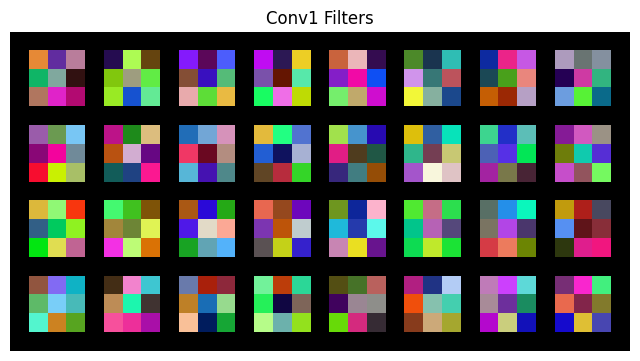

In [12]:
def visualize_first_layer_filters(model):
    filters = model.conv_layers[0][0].weight.data.clone()
    filters = (filters - filters.min()) / (filters.max() - filters.min())  # Normalize
    grid = make_grid(filters, nrow=8, normalize=True, padding=1)
    plt.figure(figsize=(8, 8))
    plt.title("Conv1 Filters")
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

visualize_first_layer_filters(best_model)

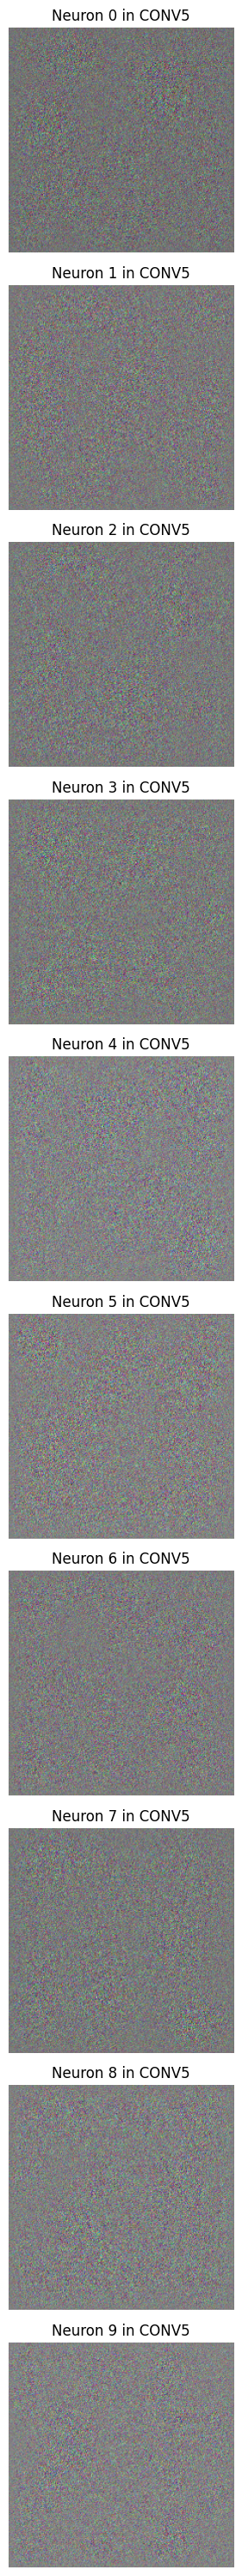

In [13]:
class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None

        def relu_hook_function(module, grad_in, grad_out):
            return (torch.clamp(grad_in[0], min=0.0),)

        for module in self.model.modules():
            if isinstance(module, torch.nn.ReLU):
                module.register_backward_hook(relu_hook_function)

    def generate_gradients(self, input_image, target_layer_idx=4, filter_idx=0):
        input_image.requires_grad = True

        x = input_image
        for i in range(target_layer_idx + 1):
            x = self.model.conv_layers[i](x)
        x[:, filter_idx].mean().backward(retain_graph=True)

        grad = input_image.grad[0].cpu().permute(1, 2, 0).numpy()
        grad = (grad - grad.min()) / (grad.max() - grad.min())
        return grad

def plot_guided_backprop(model, dataloader, num_filters=10):
    gbp = GuidedBackprop(model)

    for images, _ in dataloader:
        image = images[0:1].to(device)
        break  # Use one image

    fig, axes = plt.subplots(num_filters, 1, figsize=(5, num_filters * 3))
    for i in range(num_filters):
        grad = gbp.generate_gradients(image.clone(), filter_idx=i)
        axes[i].imshow(grad)
        axes[i].axis('off')
        axes[i].set_title(f"Neuron {i} in CONV5")

    plt.tight_layout()
    plt.show()

plot_guided_backprop(best_model, test_loader)
